# Описание проекта

Предоставлены данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. 

Первая задача — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. 

Почему бизнесу это важно: удовлетворённость работой напрямую влияет на отток сотрудников. А предсказание оттока — одна из важнейших задач HR-аналитиков. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник.

Вторая задача — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

# Задача 1: предсказание уровня удовлетворённости сотрудника

Для этой задачи заказчик предоставил данные с признаками:

- `id` — уникальный идентификатор сотрудника;

- `dept` — отдел, в котором работает сотрудник;

- `level` — уровень занимаемой должности;

- `workload` — уровень загруженности сотрудника;

- `employment_years` — длительность работы в компании (в годах);

- `last_year_promo` — показывает, было ли повышение за последний год;

- `last_year_violations` — показывает, нарушал ли сотрудник трудовой договор за последний год;

- `supervisor_evaluation` — оценка качества работы сотрудника, которую дал руководитель;

- `salary` — ежемесячная зарплата сотрудника;

- `job_satisfaction_rate` — уровень удовлетворённости сотрудника работой в компании, целевой признак.

# Импорты

In [219]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import (StandardScaler, OneHotEncoder,
                                   OrdinalEncoder, LabelEncoder,
                                   MinMaxScaler)
from sklearn.model_selection import (GridSearchCV, RandomizedSearchCV)
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import (roc_auc_score,make_scorer)
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import (DecisionTreeClassifier, DecisionTreeRegressor)
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

%pip install -q phik 
import phik

RANDOM_STATE = 42


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


# Функции

Функция для построения ящика с усами и гистограммы для изучения распределения значений признака:

In [220]:
def hist_underbox(data,title=None):
    custom_params = {"axes.spines.right": False, "axes.spines.top": False};
    sns.set_theme(style="darkgrid", rc=custom_params);
    sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, 
                                        gridspec_kw={"height_ratios": (.15, .85)})
    sns.boxplot(x=data, ax=ax_box).set_title(title)
    sns.histplot(x=data, ax=ax_hist, kde=True)
    ax_box.set(yticks=[])
    ax_box.set_xlabel("")
    ax_hist.set_ylabel("Количество")
    sns.despine(ax=ax_hist)
    sns.despine(ax=ax_box, left=True)
    mean = ax_hist.axvline(data.mean(), color='r', lw=2)
    median = ax_hist.axvline(data.median(), color='k', ls='--', lw=2)
    ax_hist.legend([mean, median], [f'Среднее значение = {round(data.mean(),2)}',
                                    f'Медиана = {round(data.median(),2)}'],
                                    loc='best')

In [221]:
def countplot_underbox(data,title=None):
    custom_params = {"axes.spines.right": False, "axes.spines.top": False};
    sns.set_theme(style="darkgrid", rc=custom_params);
    sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, 
                                        gridspec_kw={"height_ratios": (.15, .85)})
    sns.boxplot(x=data, ax=ax_box).set_title(title)
    sns.countplot(x=data, ax=ax_hist)
    ax_box.set(yticks=[])
    ax_box.set_xlabel("")
    ax_hist.set_ylabel("Количество")
    sns.despine(ax=ax_hist)
    sns.despine(ax=ax_box, left=True)
    mean = ax_hist.axvline(data.mean(), color='r', lw=2)
    median = ax_hist.axvline(data.median(), color='k', ls='--', lw=2)
    ax_hist.legend([mean, median], [f'Среднее значение = {round(data.mean(),2)}',
                                    f'Медиана = {round(data.median(),2)}'],
                                    loc='best')

In [222]:
def hist_underbox_norm(data,title=None):
    custom_params = {"axes.spines.right": False, "axes.spines.top": False};
    sns.set_theme(style="darkgrid", rc=custom_params);
    sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, 
                                        gridspec_kw={"height_ratios": (.15, .85)})
    sns.boxplot(x=data, ax=ax_box).set_title(title)
    sns.histplot(x=data, ax=ax_hist, kde=True,stat='density', common_norm=False)
    ax_box.set(yticks=[])
    ax_box.set_xlabel("")
    ax_hist.set_ylabel("плотность распределения")
    sns.despine(ax=ax_hist)
    sns.despine(ax=ax_box, left=True)
    mean = ax_hist.axvline(data.mean(), color='r', lw=2)
    median = ax_hist.axvline(data.median(), color='k', ls='--', lw=2)
    ax_hist.legend([mean, median], [f'Среднее значение = {round(data.mean(),2)}',
                                    f'Медиана = {round(data.median(),2)}'],
                                    loc='best')

функция для построения круговой диаграммы:

In [223]:
def pie_plot(data,index=None, values=None, aggfunc=None,title=None):
    pivot = data.pivot_table(index=index, values=values, aggfunc=aggfunc)
    pivot.columns = [aggfunc]
    pivot = pivot.reset_index()
    pivot.plot(y=aggfunc,kind='pie',figsize=(5,5),
               autopct='%1.2f%%',labels=pivot[index],
               colors= sns.color_palette());
    plt.title(title, color='black');
    plt.ylabel('');
    plt.legend('');

In [224]:
def pie_plot_ax(data,index=None, values=None, aggfunc=None,title=None,ax=None):
    pivot = data.pivot_table(index=index, values=values, aggfunc=aggfunc)
    pivot.columns = [aggfunc]
    pivot = pivot.reset_index()
    pivot.plot(y=aggfunc,kind='pie',
               #figsize=(5,5),
               autopct='%1.2f%%',labels=pivot[index],
               colors= sns.color_palette(),
               ax=ax);
    ax.set_title(title)
    ax.legend('')
    ax.set(ylabel=None)

Функция для вывода уникальных значений в столбцах с категориальными значениями и типом данных `str`:

In [225]:
def unique_vals(df):
    for col in np.array(df.columns):
        if type(df.loc[1,col]) == str:
            print(f'Уникальные значения в столбце {col}:',df[col].unique())

# Шаг 1. Загрузка данных

In [226]:
try:
    satisfaction_train = pd.read_csv(
        '/Users/semenobodenko/practicum/Sbornn/train_job_satisfaction_rate.csv',
        sep=',', decimal=".")
except:
    try:
        satisfaction_train = pd.read_csv(
            '/datasets/train_job_satisfaction_rate.csv', sep=',', decimal=".")
    except:
        try:
            satisfaction_train = pd.read_csv(
                '/content/drive/MyDrive/ColabNotebooks/datasets/MachineLearningProjects/train_job_satisfaction_rate.csv',
                sep=',', decimal=".")
        except:
            satisfaction_train = pd.read_csv(
                '/Users/semeon5obdk/prakticum/Sbornn/train_job_satisfaction_rate.csv',
                sep=',', decimal=".")

In [227]:
try:
    test_features = pd.read_csv(
        '/Users/semenobodenko/practicum/Sbornn/test_features.csv', sep=',', decimal=".")
except:
    try:
        test_features = pd.read_csv(
            '/datasets/test_features.csv', sep=',', decimal=".")
    except:
        try:
            test_features = pd.read_csv(
                '/content/drive/MyDrive/ColabNotebooks/datasets/MachineLearningProjects/test_features.csv', sep=',', decimal=".")
        except:
            test_features = pd.read_csv('/Users/semeon5obdk/prakticum/Sbornn/test_features.csv', sep=',', decimal=".")

In [228]:
try:
    test_target = pd.read_csv(
        '/Users/semenobodenko/practicum/Sbornn/test_target_job_satisfaction_rate.csv',
        sep=',', decimal=".")
except:
    try:
        test_target = pd.read_csv(
            '/datasets/test_target_job_satisfaction_rate.csv', sep=',', decimal=".")
    except:
        try:
            test_target = pd.read_csv(
                '/content/drive/MyDrive/ColabNotebooks/datasets/MachineLearningProjects/test_target_job_satisfaction_rate.csv',
                sep=',', decimal=".")
        except:
            test_target = pd.read_csv(
                '/Users/semeon5obdk/prakticum/Sbornn/test_target_job_satisfaction_rate.csv',
                sep=',', decimal=".")

In [229]:
satisfaction_train.head(5)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [230]:
satisfaction_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


In [231]:
satisfaction_test = test_features.merge(test_target,on='id')

In [232]:
satisfaction_test.head(5)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,485046,marketing,junior,medium,2,no,no,5,28800,0.79
1,686555,hr,junior,medium,1,no,no,4,30000,0.72
2,467458,sales,middle,low,5,no,no,4,19200,0.64
3,418655,sales,middle,low,6,no,no,4,19200,0.60
4,789145,hr,middle,medium,5,no,no,5,40800,0.75


In [233]:
satisfaction_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   dept                   1998 non-null   object 
 2   level                  1999 non-null   object 
 3   workload               2000 non-null   object 
 4   employment_years       2000 non-null   int64  
 5   last_year_promo        2000 non-null   object 
 6   last_year_violations   2000 non-null   object 
 7   supervisor_evaluation  2000 non-null   int64  
 8   salary                 2000 non-null   int64  
 9   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 156.4+ KB


## ***Вывод***

Выяснили, что
- данные в таблицах соответствуют описанию;

- типы данных верные;

- размер датасета `satisfaction_train`: `4000 записей`;

- размер датасета `satisfaction_test` : `2000 записей`;

# Шаг 2. Предобработка данных

In [234]:
unique_vals(satisfaction_train)

Уникальные значения в столбце dept: ['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
Уникальные значения в столбце level: ['junior' 'middle' 'sinior' nan]
Уникальные значения в столбце workload: ['medium' 'high' 'low']
Уникальные значения в столбце last_year_promo: ['no' 'yes']
Уникальные значения в столбце last_year_violations: ['no' 'yes']


In [235]:
unique_vals(satisfaction_test)

Уникальные значения в столбце dept: ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
Уникальные значения в столбце level: ['junior' 'middle' 'sinior' nan]
Уникальные значения в столбце workload: ['medium' 'low' 'high' ' ']
Уникальные значения в столбце last_year_promo: ['no' 'yes']
Уникальные значения в столбце last_year_violations: ['no' 'yes']


In [236]:
satisfaction_test.loc[satisfaction_test['dept']==' ','dept'] = np.nan
satisfaction_test.loc[satisfaction_test['workload']==' ','workload'] = np.nan

In [237]:
satisfaction_train.isna().sum()

id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

In [238]:
satisfaction_test.isna().sum()

id                       0
dept                     3
level                    1
workload                 1
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

Пропуски заполним в пайплайне на шаге 4. Пропусков меньше 1%, так что их присутствие не скажется негативно на исследовательском анализе данных.

In [239]:
[satisfaction_train.duplicated().sum(),
satisfaction_test.duplicated().sum()]

[0, 0]

Дубликатов нет.

In [240]:
# исправим опечатку
satisfaction_train.loc[satisfaction_train['level']=='sinior','level'] = 'senior'
satisfaction_test.loc[satisfaction_test['level']=='sinior','level'] = 'senior'

## Выводы

Обнаружили, что

- есть пропуски, меньше 1% от всех данных
- дубликатов нет
- исправили опечатки в названиях категорий

# Шаг 3. Исследовательский анализ данных

## Инфографика по тренировочной выборке:

Посмотрим на круговые диаграммы для категориальных признаков и гистограммы для количественных признаков:

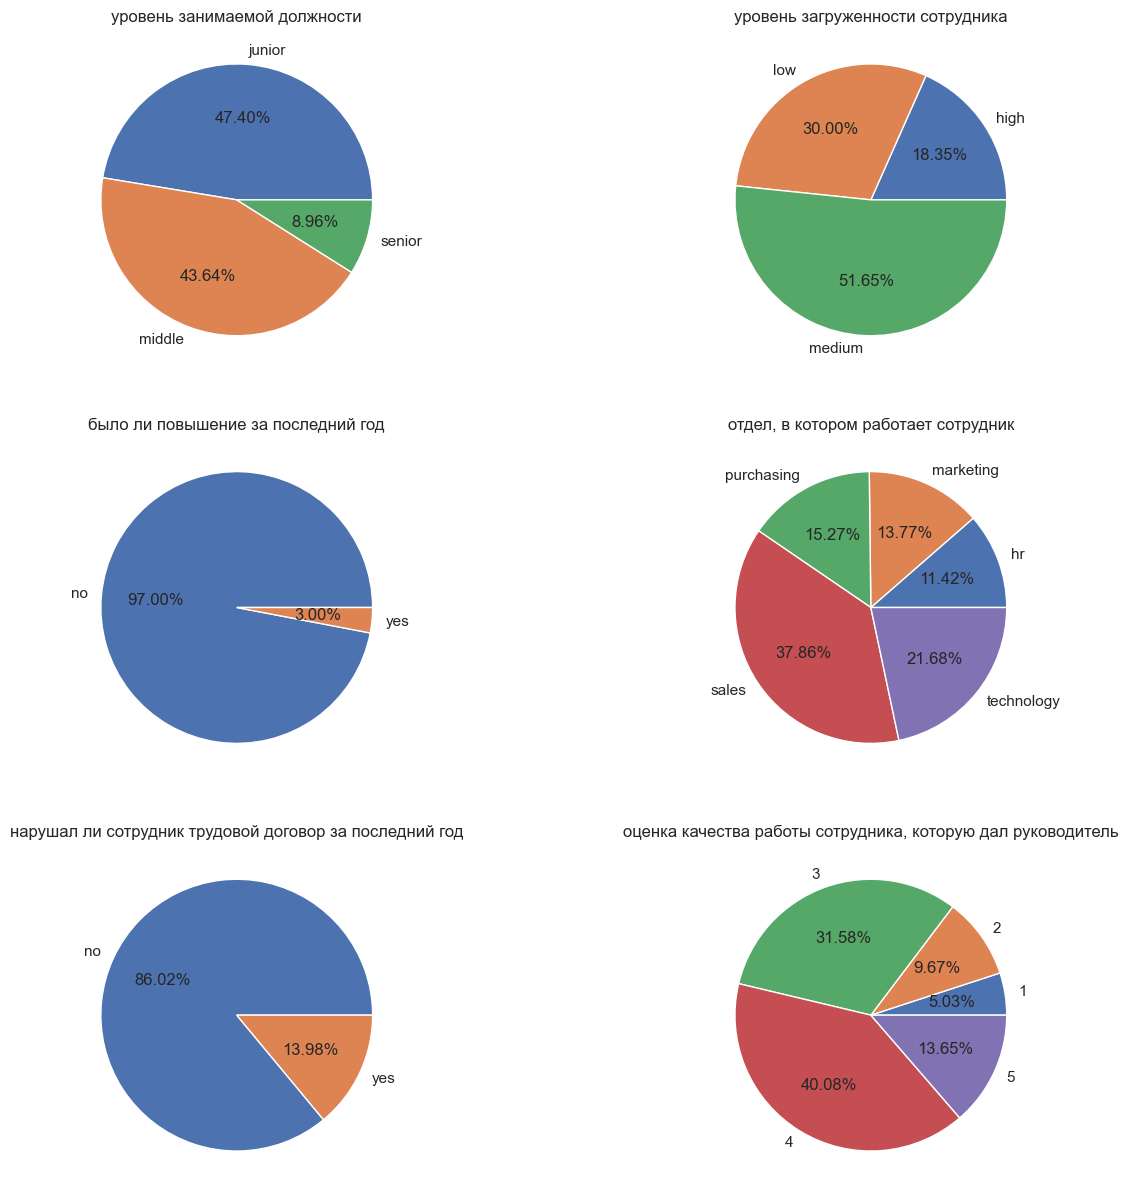

In [241]:
fig, ax = plt.subplots(3, 2, figsize=(15, 15))
pie_plot_ax(satisfaction_train, title='уровень занимаемой должности',
         index='level',values='id',aggfunc='count',ax = ax[0, 0])
pie_plot_ax(satisfaction_train, title='уровень загруженности сотрудника',
         index='workload',values='id',aggfunc='count',ax = ax[0, 1])

pie_plot_ax(satisfaction_train,title='было ли повышение за последний год',
         index='last_year_promo',values='id',aggfunc='count',ax = ax[1, 0])
pie_plot_ax(satisfaction_train, title='отдел, в котором работает сотрудник',
         index='dept',values='id',aggfunc='count',ax = ax[1, 1])

pie_plot_ax(satisfaction_train, title='нарушал ли сотрудник трудовой договор за последний год',
         index='last_year_violations',values='id',aggfunc='count',ax = ax[2, 0])
pie_plot_ax(satisfaction_train, title='оценка качества работы сотрудника, которую дал руководитель',
         index='supervisor_evaluation',values='id',aggfunc='count',ax = ax[2, 1])
plt.show()

<Figure size 800x550 with 0 Axes>

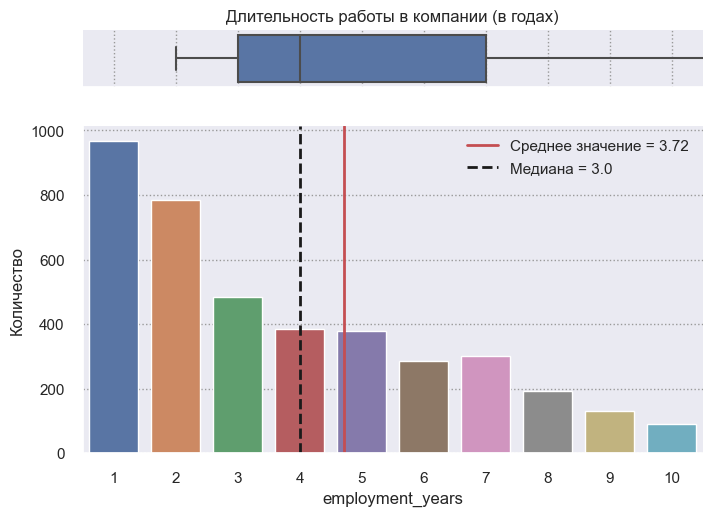

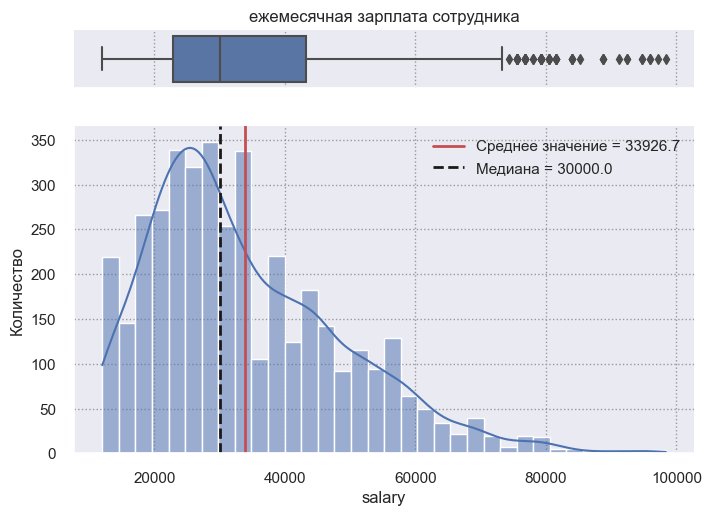

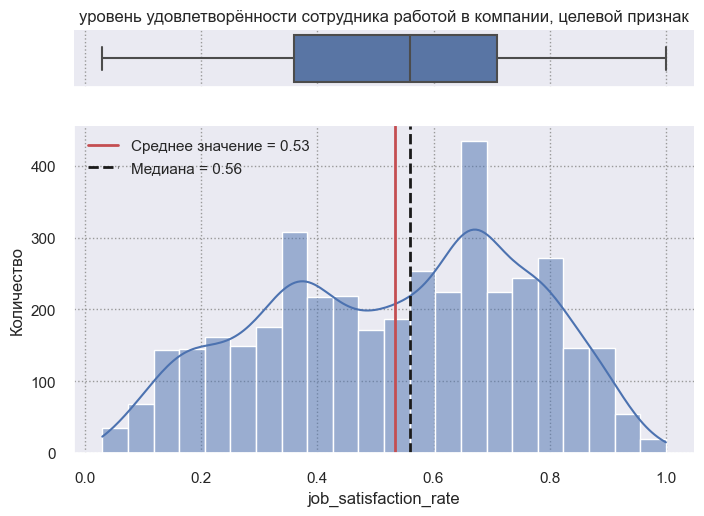

In [242]:
plt.figure(0)
countplot_underbox(satisfaction_train['employment_years'],title='Длительность работы в компании (в годах)')
plt.figure(1)
hist_underbox(satisfaction_train['salary'],title='ежемесячная зарплата сотрудника')
plt.figure(2)
hist_underbox(satisfaction_train['job_satisfaction_rate'],title='уровень удовлетворённости сотрудника работой в компании, целевой признак')
plt.show()

## Корреляционный анализ

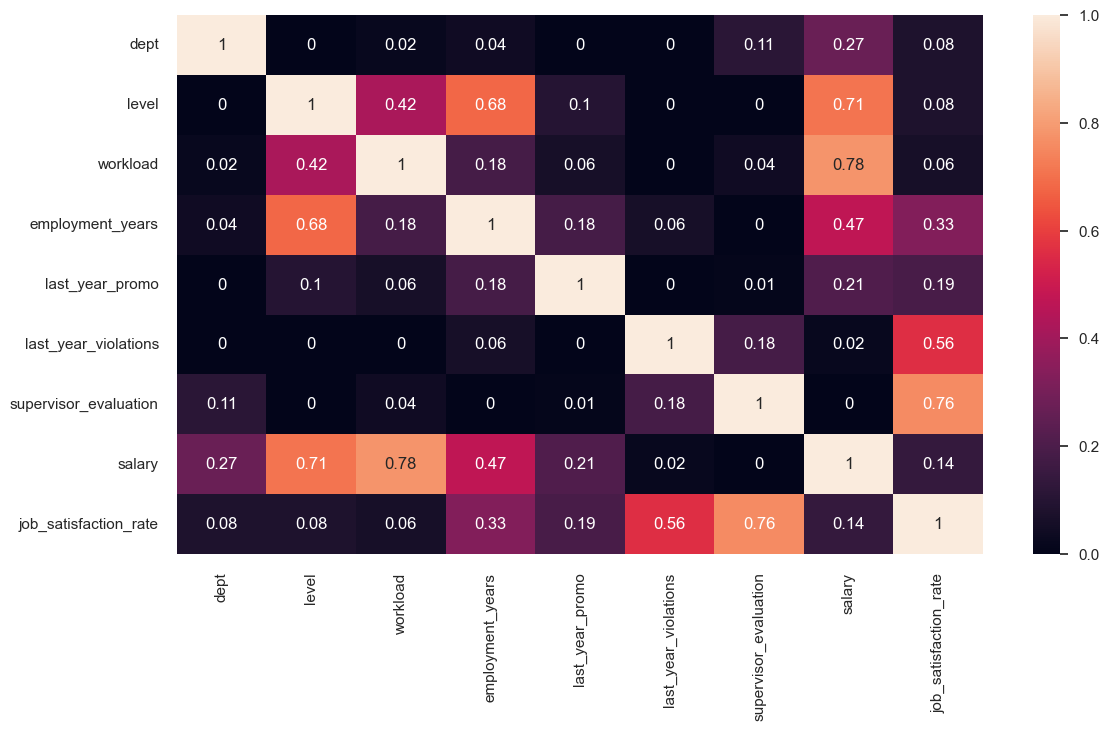

In [243]:
fig, ax = plt.subplots(figsize=(13, 7))
sns.heatmap(round(satisfaction_train.drop('id',axis=1)
                  .phik_matrix(interval_cols=['salary','job_satisfaction_rate']),2),annot=True);

Наблюдаем высокую корреляцию (0.76) уровня удовлетворённости сотрудника работой в компании с оценкой качества работы сотрудника, которую дал руководитель. Посмотрим на диаграмму рассеяния:

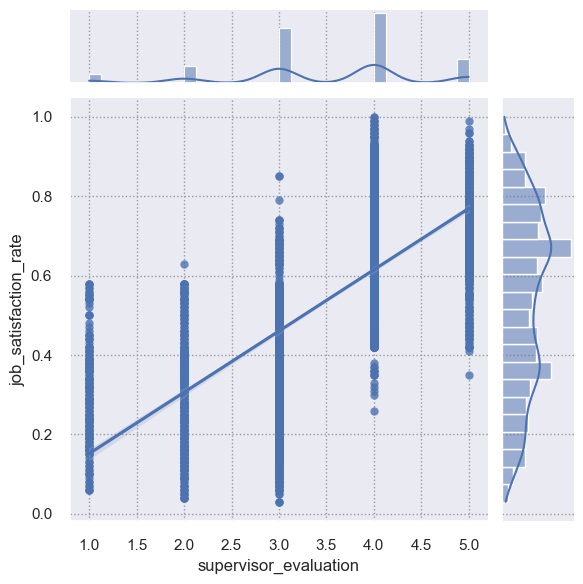

In [244]:
sns.jointplot(x='supervisor_evaluation', y='job_satisfaction_rate', data=satisfaction_train, kind='reg');

## Инфографика по тестовой выборке:

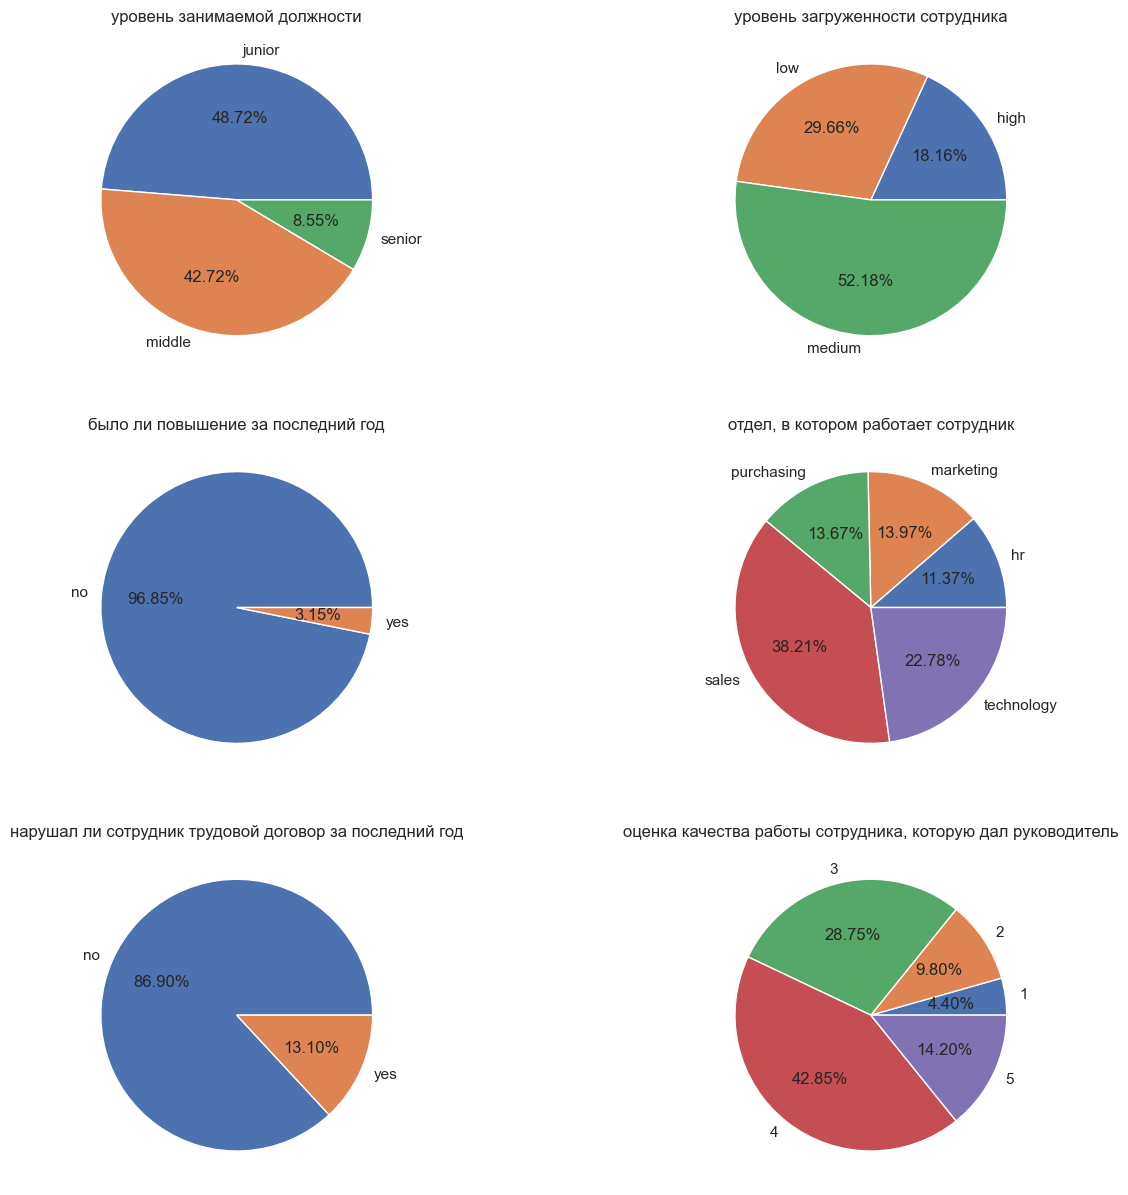

In [245]:
fig, ax = plt.subplots(3, 2, figsize=(15, 15))
pie_plot_ax(satisfaction_test, title='уровень занимаемой должности',
         index='level',values='id',aggfunc='count',ax = ax[0, 0])
pie_plot_ax(satisfaction_test, title='уровень загруженности сотрудника',
         index='workload',values='id',aggfunc='count',ax = ax[0, 1])

pie_plot_ax(satisfaction_test,title='было ли повышение за последний год',
         index='last_year_promo',values='id',aggfunc='count',ax = ax[1, 0])
pie_plot_ax(satisfaction_test, title='отдел, в котором работает сотрудник',
         index='dept',values='id',aggfunc='count',ax = ax[1, 1])

pie_plot_ax(satisfaction_test, title='нарушал ли сотрудник трудовой договор за последний год',
         index='last_year_violations',values='id',aggfunc='count',ax = ax[2, 0])
pie_plot_ax(satisfaction_test, title='оценка качества работы сотрудника, которую дал руководитель',
         index='supervisor_evaluation',values='id',aggfunc='count',ax = ax[2, 1])
plt.show()

<Figure size 800x550 with 0 Axes>

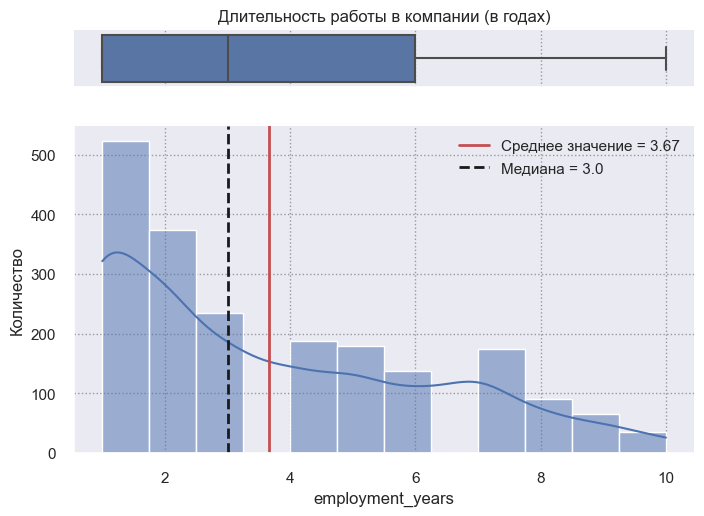

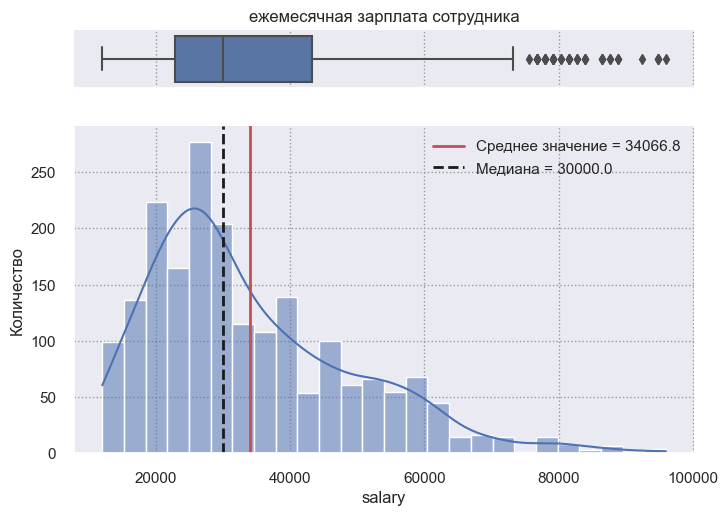

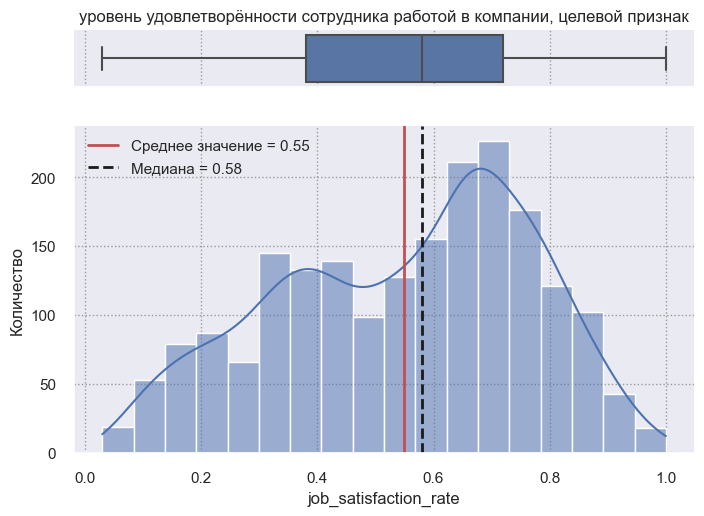

In [246]:
plt.figure(0)
hist_underbox(satisfaction_test['employment_years'],title='Длительность работы в компании (в годах)')
plt.figure(1)
hist_underbox(satisfaction_test['salary'],title='ежемесячная зарплата сотрудника')
plt.figure(2)
hist_underbox(satisfaction_test['job_satisfaction_rate'],title='уровень удовлетворённости сотрудника работой в компании, целевой признак')
plt.show()

### Выводы по общим инфографикам и корр. анализу

- инфографики по тренировочной и тестовой выборкам близки друг к другу по всем признакам
- заметен большой дисбаланс по признаку `last_year_promo` (было ли повышение за последний год)
- коллинеарностей между признаками не обнаружено
- заметили высокую корреляцию (0.76) уровня удовлетворённости сотрудника работой в компании (целевой признак) с оценкой качества работы сотрудника, которую дал руководитель
- также обнаружена заметная корреляция (0.56) целевого признака с фактом нарушения трудового договора сотрудником за последний год, и умеренная корреляция (0.33) с длительностью работы в компании.

## Сводные таблицы

Построим сводную таблицу с медианными значениями уровня удовлетворенности работой для сотрудников в зависимости от отдела, в котором они работают, должности, и уровня загруженности:

In [247]:
dept_lev_pt = satisfaction_train.pivot_table(
    index=['dept','level','workload'],values='job_satisfaction_rate',aggfunc='median'
)
dept_lev_pt.columns = ['job_satisfac_rate_median']
dept_lev_pt = dept_lev_pt.reset_index()
dept_lev_pt_workload = dept_lev_pt.pivot_table(index=['dept','level'],
                        columns='workload',values='job_satisfac_rate_median')
dept_lev_pt_workload.columns = ['high_workload','low_workload','medium_workload']
dept_lev_pt_workload = dept_lev_pt_workload.reset_index()
dept_lev_pt_workload

,dept,level,high_workload,low_workload,medium_workload
0,hr,junior,0.660,0.565,0.480
1,hr,middle,0.575,0.620,0.575
2,hr,senior,0.640,0.610,0.590
3,marketing,junior,0.450,0.650,0.465
4,marketing,middle,0.530,0.535,0.430
5,marketing,senior,0.560,0.490,0.500
6,purchasing,junior,0.610,0.600,0.580
7,purchasing,middle,0.580,0.590,0.580
8,purchasing,senior,0.580,0.720,0.590
9,sales,junior,0.640,0.520,0.535


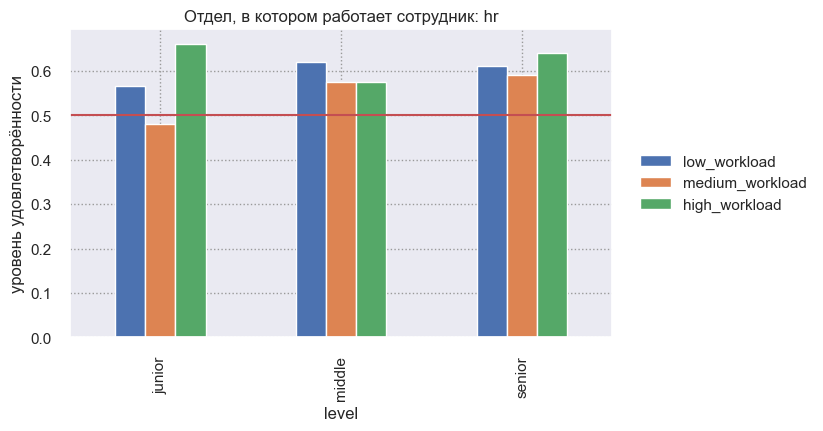

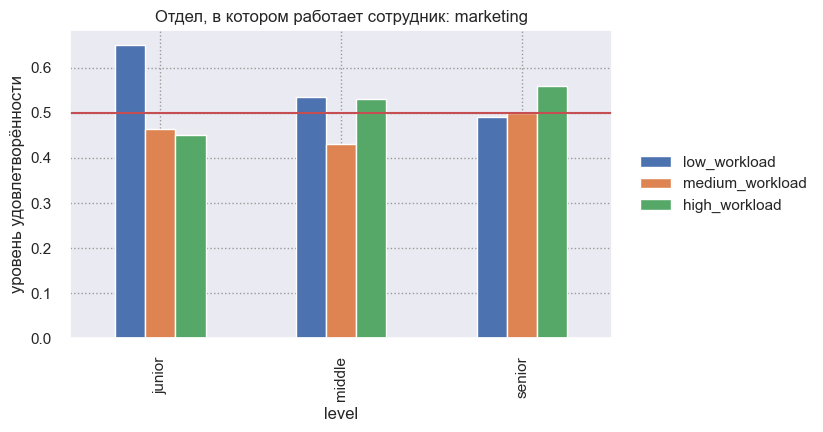

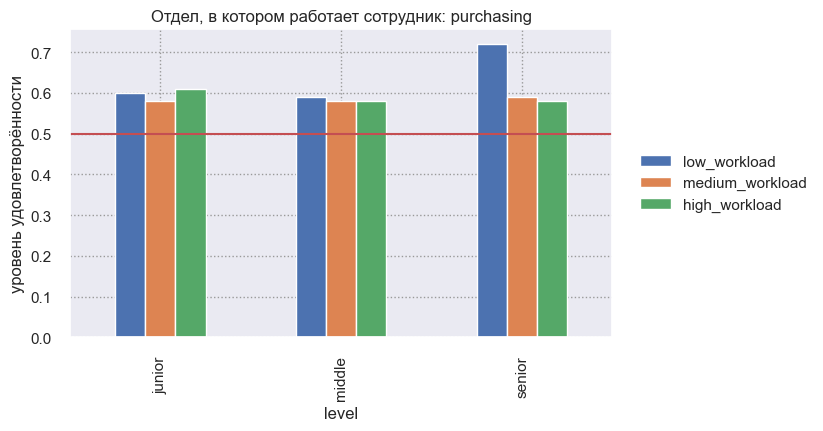

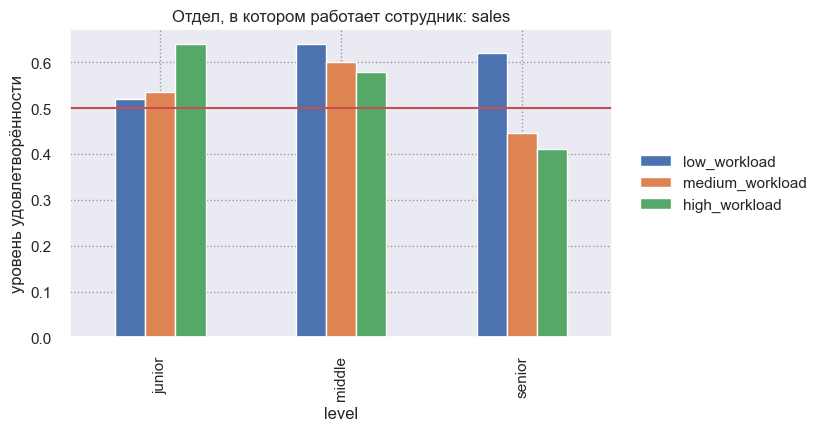

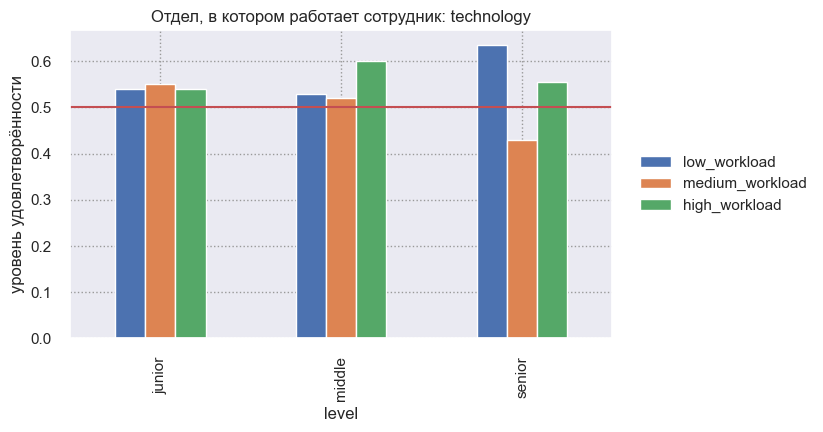

In [248]:
for dept in dept_lev_pt_workload.dept.unique():
    fig = dept_lev_pt_workload[dept_lev_pt_workload['dept']==dept].plot.bar(x='level',y=['low_workload','medium_workload','high_workload'],
                    grid=True,figsize=(7, 4));
    plt.title(f'Отдел, в котором работает сотрудник: {dept}')
    plt.ylabel('уровень удовлетворённости')
    plt.axhline(y=0.5, color='r', linestyle='-')
    plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)
    plt.show()


### Выводы

Если значение уровня удовлетворенности сотрудника его работой в компании в 0.5 можно принять за пороговое значение, по которому можно сказать удовлетворен / не удовлетворен, то видим, что:
- в отделе `purchasing` удовлетворены все
- в отделе `technology` не удовлетворены работой только сотрудники в должности `senior` со средним уровнем загруженности
- в отделе `hr` не удовлетворены только `junior`-сотрудники со средней загруженностью
- в отделе `sales` не удовлетворены работой сотрудники в должности `senior` со средним и высоким уровнями загруженности
- в отделе `marketing` не удовлетворены работой сотрудники должности `junior` со средней и высокой загруженностями, сотрудники с должностью `middle` со средним уровнем загруженности, а так же `senior` с низким и средним уровнями загруженности

Также, если поделить сотрудников по порогу в 0.5 и построить для обеих групп свою инфографику (см. Приложение), как в начале этого шага, то для обоих групп выясняется следующее:

- удовлетворенным сотрудникам более чем в два раза чаще давали повышение за последний год, чем неудовлетворенным (4.03% vs 1.66%)
- удовлетворенные сотрудники почти в 5 раз реже нарушали трудовой договор, чем неудовлетворенные
- оценки качества работы удовлетворенных сотрудников, которые дал руководитель, тоже заметно отличаются: "отличников" в 9 раз больше, "хорошистов" в 8 больше, "троишников" в 6 раз меньше, а сотрудников с неудовлетворительным качеством работы в 12 раз меньше, чем у неудовлетворенных сотрудников
- длительность работы в компании у удовлетворенных сотрудников в среднем больше на полгода
- ежемесячная зарплата удовлетворенного работой сотрудника в среднем больше на 2400

Выводы о том, как нужно подготовить данные:

- категориальные признаки закодировать, в том числе с помощью `OrdinalEncoder` (признаки `level`,`workload`)
- количественные признаки масштабировать

# Шаг 4. Подготовка данных

Подготовку признаков выполним в пайплайне, дополнив пайплайн шага предобработки. При кодировании учтем особенности признаков и моделей и используем два кодировщика.

In [249]:
X_train = satisfaction_train.drop(['id'], axis=1).drop_duplicates().copy()
X_train = X_train.drop(['job_satisfaction_rate'], axis=1)

y_train = satisfaction_train.drop(['id'], axis=1).drop_duplicates().copy()
y_train = y_train['job_satisfaction_rate']

X_test = satisfaction_test.copy()
X_test = X_test.drop(['job_satisfaction_rate','id'], axis=1)

y_test = satisfaction_test.copy()
y_test = y_test['job_satisfaction_rate']

X_train.shape, X_test.shape

((3755, 8), (2000, 8))

In [250]:
y_train.shape, y_test.shape

((3755,), (2000,))

In [251]:
# создаём списки с названиями признаков
ohe_columns = ['dept','last_year_promo','last_year_violations']
ord_columns = ['workload','level']
num_columns = ['employment_years','supervisor_evaluation','salary']

In [252]:
# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
    )
# создаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
# SimpleImputer + OE
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['low', 'medium','high'],
                    ['junior', 'middle', 'senior']
                ]
            )
        ),
    ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

# Шаг 5. Обучение моделей

Обучим две модели. Возьмем одну линейную модель, а в качестве второй — дерево решений. Подберем гиперпараметры.

Выберем лучшую модель и проверим её качество. Выбор сделаем на основе SMAPE (англ. symmetric mean absolute percentage error, «симметричное среднее абсолютное процентное отклонение»). 

Метрика SMAPE вычисляется так:
$$
SMAPE = \frac{100}{n} \sum_{i=1}^n \frac{|y_i - \hat{y_i}|}{(|y_i|+|\hat{y_i}|)/2}
$$
где:
- $y_i$ — фактическое значение целевого признака для объекта с порядковым номером $i$ в выборке;
- $\hat{y_i}$ — предсказанное значение целевого признака для объекта с порядковым номером $i$ в выборке;
- $n$ — количество объектов в выборке;
- $\sum_{i=1}^n$ — сумма значений, полученная в результате операций, которые следуют за этим знаком, для всех объектов с порядковым номером от $i$ до $n$ в выборке.

Напишем функцию, которая принимает на вход массивы NumPy или объекты `Series` в pandas и возвращает значение метрики SMAPE. Используем эту метрику при подборе гиперпараметров и оценке качества моделей. 

Критерий успеха: SMAPE $≤15$ на тестовой выборке.

In [253]:
def smape(y_true, y_pred):
    return 100 * np.mean(np.abs(y_pred - y_true) / ((np.abs(y_pred) + np.abs(y_true))/2))
 
# Создаем объект-оценщик для использования SMAPE в GridSearchCV
smape_scorer = make_scorer(smape, greater_is_better=False)

In [254]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

param_grid = [
    # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': (None, *range(1, 5)),
        'models__min_samples_split': range(2, 15),
        'models__min_samples_leaf': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    
    # словарь для модели LinearRegression() 
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
]

In [255]:
grid = GridSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring=smape_scorer,
    n_jobs=-1, error_score='raise'
)
grid.fit(X_train, y_train)

best_model = grid.best_estimator_
best_params = grid.best_params_
 
# Оцениваем качество на тестовой выборке
y_test_pred = best_model.predict(X_test)
smape_test = smape(y_test, y_test_pred)
 
# Выводим значение SMAPE на тестовой выборке
print ('SMAPE лучшей модели на кросс-валидации:', grid.best_score_ * -1)
print ('SMAPE на тестовой выборке равна:', smape_test)
print ('Лучшая модель и её параметры:\n', grid.best_estimator_)

SMAPE лучшей модели на кросс-валидации: 15.056819677662935
SMAPE на тестовой выборке равна: 13.594851272563588
Лучшая модель и её параметры:
 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   '

## Вывод

- создали метрику SMAPE для дальнешего применения в оценке модели
- сформировали сетку параметров для двух моделей для поиска лучшей с помощью GridSearchCV
- нашли лучшую модель: DecisionTreeRegressor с min_samples_leaf=3, метрика SMAPE на тестовой выборке равна: 13.6%

# Шаг 6. Выводы

Лучше всего справилась модель 
```python
{'models': DecisionTreeRegressor(random_state=42),
 'models__max_depth': None,
 'models__min_samples_leaf': 1,
 'models__min_samples_split': 8,
 'preprocessor__num': MinMaxScaler()}
 ```
Метрика SMAPE на тестовой выборке равна: 13.6 %

Вполне возможно, что это обусловлено тем, что DecisionTreeRegressor с кластеризированными данными и с нелинейными отношениями в данных работает лучше, чем линейная регрессия, которая сильно зависит от наличия линейных зависимостей в данных.

# Задача 2: предсказание увольнения сотрудника из компании

# Шаг 1. Загрузка данных

In [256]:
try:
    train_quit = pd.read_csv(
        '/Users/semenobodenko/practicum/Sbornn/train_quit.csv',
        sep=',', decimal=".")
except:
    try:
        train_quit = pd.read_csv(
            '/datasets/train_quit.csv', sep=',', decimal=".")
    except:
        try:
            train_quit = pd.read_csv(
                '/content/drive/MyDrive/ColabNotebooks/datasets/MachineLearningProjects/train_quit.csv',
                sep=',', decimal=".")
        except:
            train_quit = pd.read_csv(
                '/Users/semeon5obdk/prakticum/Sbornn/train_quit.csv',
                sep=',', decimal=".")

In [257]:
try:
    test_target_quit = pd.read_csv(
        '/Users/semenobodenko/practicum/Sbornn/test_target_quit.csv',
        sep=',', decimal=".")
except:
    try:
        test_target_quit = pd.read_csv(
            '/datasets/test_target_quit.csv', sep=',', decimal=".")
    except:
        try:
            test_target_quit = pd.read_csv(
                '/content/drive/MyDrive/ColabNotebooks/datasets/MachineLearningProjects/test_target_quit.csv',
                sep=',', decimal=".")
        except:
            test_target_quit = pd.read_csv(
                '/Users/semeon5obdk/prakticum/Sbornn/test_target_quit.csv',
                sep=',', decimal=".")

In [258]:
test_quit = test_features.merge(test_target_quit,on='id')

In [259]:
test_quit.head(3)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,485046,marketing,junior,medium,2,no,no,5,28800,no
1,686555,hr,junior,medium,1,no,no,4,30000,no
2,467458,sales,middle,low,5,no,no,4,19200,no


In [260]:
test_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
 9   quit                   2000 non-null   object
dtypes: int64(4), object(6)
memory usage: 156.4+ KB


In [261]:
train_quit.head(3)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no


In [262]:
train_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


# Шаг 2. Предобработка данных

In [263]:
unique_vals(test_quit)

Уникальные значения в столбце dept: ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
Уникальные значения в столбце level: ['junior' 'middle' 'sinior' nan]
Уникальные значения в столбце workload: ['medium' 'low' 'high' ' ']
Уникальные значения в столбце last_year_promo: ['no' 'yes']
Уникальные значения в столбце last_year_violations: ['no' 'yes']
Уникальные значения в столбце quit: ['no' 'yes']


In [264]:
test_quit.loc[test_quit['dept']==' ','dept'] = np.nan
test_quit.loc[test_quit['workload']==' ','workload'] = np.nan

In [265]:
unique_vals(test_quit)

Уникальные значения в столбце dept: ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan]
Уникальные значения в столбце level: ['junior' 'middle' 'sinior' nan]
Уникальные значения в столбце workload: ['medium' 'low' 'high' nan]
Уникальные значения в столбце last_year_promo: ['no' 'yes']
Уникальные значения в столбце last_year_violations: ['no' 'yes']
Уникальные значения в столбце quit: ['no' 'yes']


In [266]:
# исправим опечатку
train_quit.loc[train_quit['level']=='sinior','level'] = 'senior'
test_quit.loc[test_quit['level']=='sinior','level'] = 'senior'

In [267]:
[train_quit.duplicated().sum(),
test_quit.duplicated().sum()]

[0, 0]

Дубликатов нет.

Ситуация с пропусками аналогична ситуации из первой задачи. Расправимся с пропусками в пайплайне.

## Выводы

Обнаружили, что

- есть пропуски, меньше 1% от всех данных
- дубликатов нет
- исправили опечатки в названиях категорий

# Шаг 3. Исследовательский анализ данных

Составим портрет «уволившегося сотрудника».

Сначала добавим признак `job_satisfaction_rate` с помощью полученной в предыдущей задаче модели:

In [268]:
X_train_quit = train_quit.drop(['id','quit'], axis=1)
X_test_quit = test_quit.drop(['id','quit'], axis=1)

job_satisfaction_rate_for_train_quit = best_model.predict(X_train_quit)
job_satisfaction_rate_for_test_quit = best_model.predict(X_test_quit)

train_quit = pd.concat([train_quit,pd.DataFrame(job_satisfaction_rate_for_train_quit)], axis=1)
test_quit = pd.concat([test_quit,pd.DataFrame(job_satisfaction_rate_for_test_quit)], axis=1)
train_quit = train_quit.rename(columns={0: 'job_satisfaction_rate'})
test_quit = test_quit.rename(columns={0: 'job_satisfaction_rate'})

## Инфографика по тренировочным данным

Инфографика по уволившимся (левый столбец графиков) и оставшимся сотрудникам (правый):

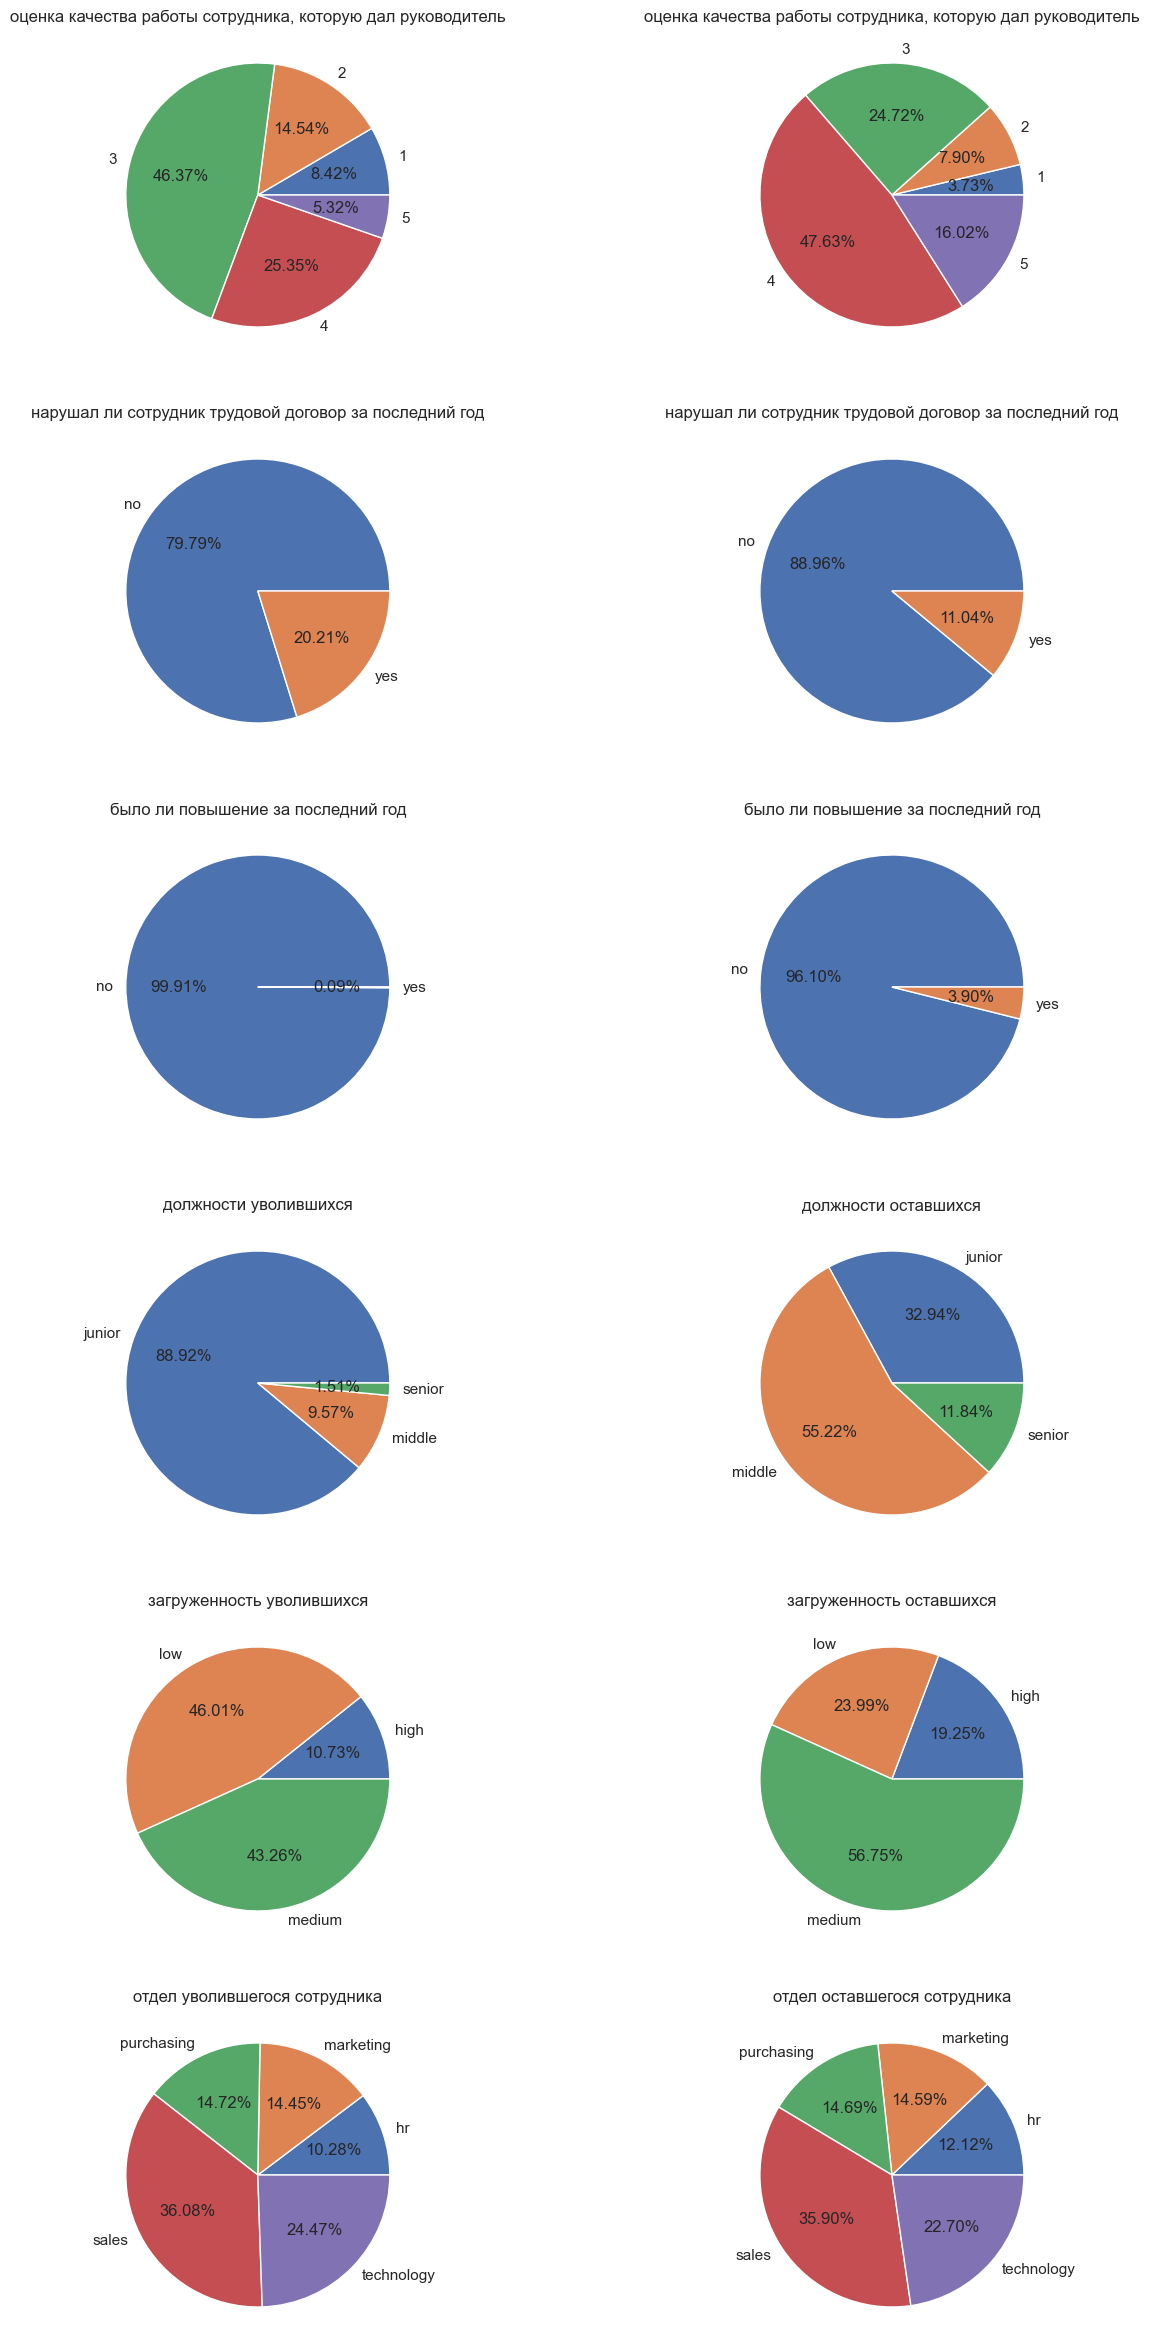

In [269]:
fig, ax = plt.subplots(6, 2, figsize=(15, 30))
pie_plot_ax(train_quit[train_quit['quit']=='yes'], title='оценка качества работы сотрудника, которую дал руководитель',
         index='supervisor_evaluation',values='id',aggfunc='count',ax = ax[0, 0])
pie_plot_ax(train_quit[train_quit['quit']=='no'], title='оценка качества работы сотрудника, которую дал руководитель',
         index='supervisor_evaluation',values='id',aggfunc='count',ax = ax[0, 1])

pie_plot_ax(train_quit[train_quit['quit']=='yes'], title='нарушал ли сотрудник трудовой договор за последний год',
         index='last_year_violations',values='id',aggfunc='count',ax = ax[1, 0])
pie_plot_ax(train_quit[train_quit['quit']=='no'], title='нарушал ли сотрудник трудовой договор за последний год',
         index='last_year_violations',values='id',aggfunc='count',ax = ax[1, 1])

pie_plot_ax(train_quit[train_quit['quit']=='yes'],title='было ли повышение за последний год',
         index='last_year_promo',values='id',aggfunc='count',ax = ax[2, 0])
pie_plot_ax(train_quit[train_quit['quit']=='no'],title='было ли повышение за последний год',
         index='last_year_promo',values='id',aggfunc='count',ax = ax[2, 1])

pie_plot_ax(train_quit[train_quit['quit']=='yes'],title='должности уволившихся',
         index='level',values='id',aggfunc='count',ax = ax[3, 0])
pie_plot_ax(train_quit[train_quit['quit']=='no'],title='должности оставшихся',
         index='level',values='id',aggfunc='count',ax = ax[3, 1])

pie_plot_ax(train_quit[train_quit['quit']=='yes'],title='загруженность уволившихся',
         index='workload',values='id',aggfunc='count',ax = ax[4, 0])
pie_plot_ax(train_quit[train_quit['quit']=='no'],title='загруженность оставшихся',
         index='workload',values='id',aggfunc='count',ax = ax[4, 1])

pie_plot_ax(train_quit[train_quit['quit']=='yes'],title='отдел уволившегося сотрудника',
         index='dept',values='id',aggfunc='count',ax = ax[5, 0])
pie_plot_ax(train_quit[train_quit['quit']=='no'],title='отдел оставшегося сотрудника',
         index='dept',values='id',aggfunc='count',ax = ax[5, 1])

plt.show()

ежемесячная зарплата уволившегося и не уволившегося сотрудников:

<Figure size 800x550 with 0 Axes>

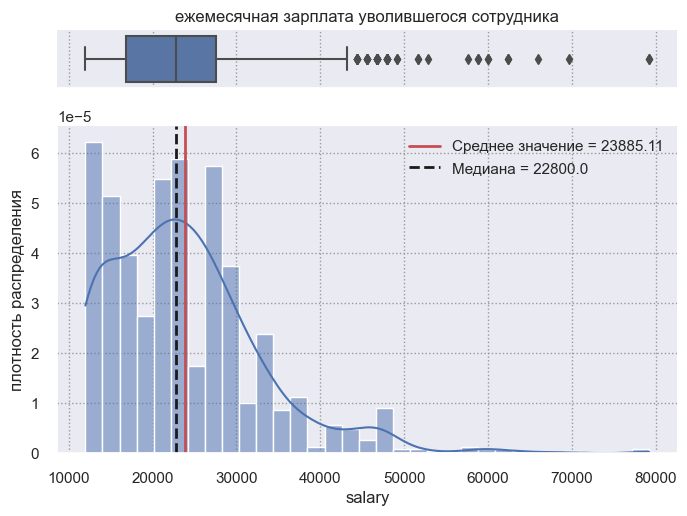

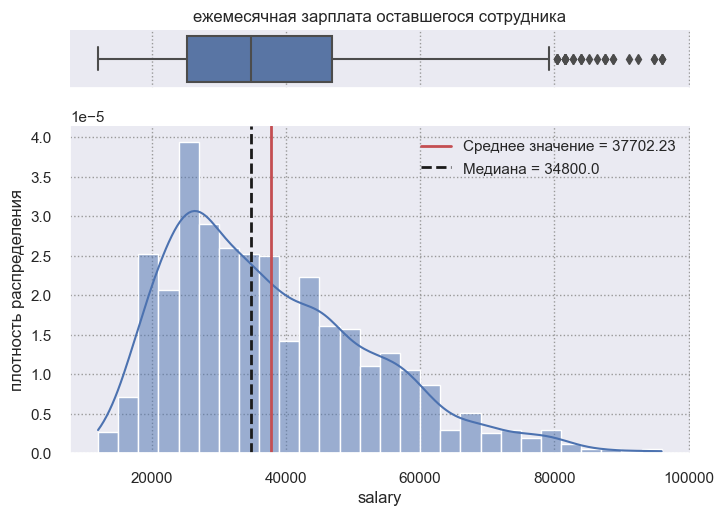

In [270]:
plt.figure(0)
hist_underbox_norm(train_quit.loc[train_quit['quit']=='yes','salary'],title='ежемесячная зарплата уволившегося сотрудника')
plt.figure(1)
hist_underbox_norm(train_quit.loc[train_quit['quit']=='no','salary'],title='ежемесячная зарплата оставшегося сотрудника')
plt.show()

Стаж работы в компании:

<Figure size 800x550 with 0 Axes>

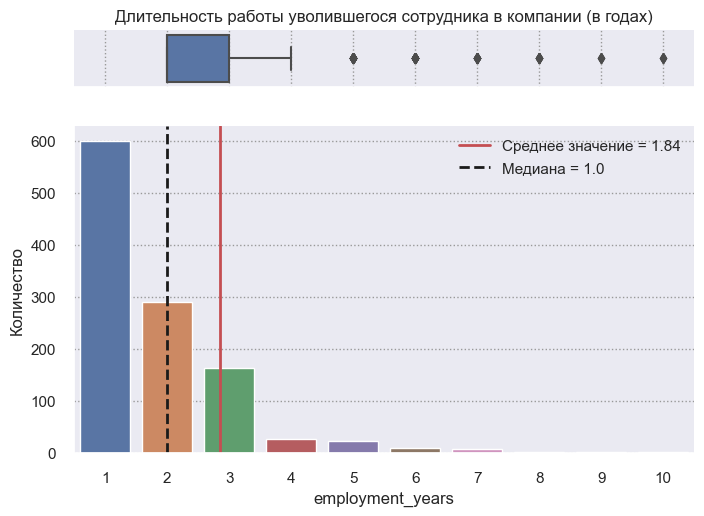

<Figure size 800x550 with 0 Axes>

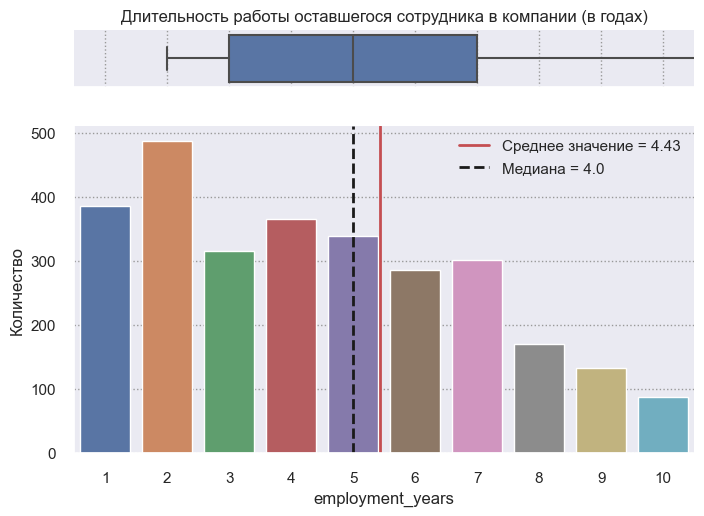

In [271]:
plt.figure(0);
countplot_underbox(train_quit.loc[train_quit['quit']=='yes','employment_years'],title='Длительность работы уволившегося сотрудника в компании (в годах)');
plt.figure(2);
countplot_underbox(train_quit.loc[train_quit['quit']=='no','employment_years'],title='Длительность работы оставшегося сотрудника в компании (в годах)');
plt.show();

Видим, что 
- "отличников" (оценка руководителя = 5) ***у не уволившихся*** сотрудников в три раза больше, "хорошистов" - почти в два раза. Тогда как среди уволившихся почти в два раза больше "троешников", как и сотрудников с неудовлетворительным качеством работы
- среди уволившихся сотрудников нарушали трудовой договор за последний год почти в 2 раза чаще
- в 43 раза чаще давали повышение сотрудникам, которые по итогу остались
- из уволившихся всего 1.51% - сотрудники должности "senior", тогда как "middle" сотрудников - 9.57%, и 88.92% - "junior"
- оставшиеся сотрудники работали больше - средняя и высокая загруженность сотрудника встречались заметно чаще (56.75% и 19.25% соответственно против 43.26% и 10.73 у уволившихся)
- зарплаты оставшихся сотрудников в среднем на 14 больше, чем у уволившихся (медианная зарплата больше на 12)
- медианное значение стажа работы среди уволившихся равно 1 году, среди оставшихся - 4

## Инфографика по тестовым данным

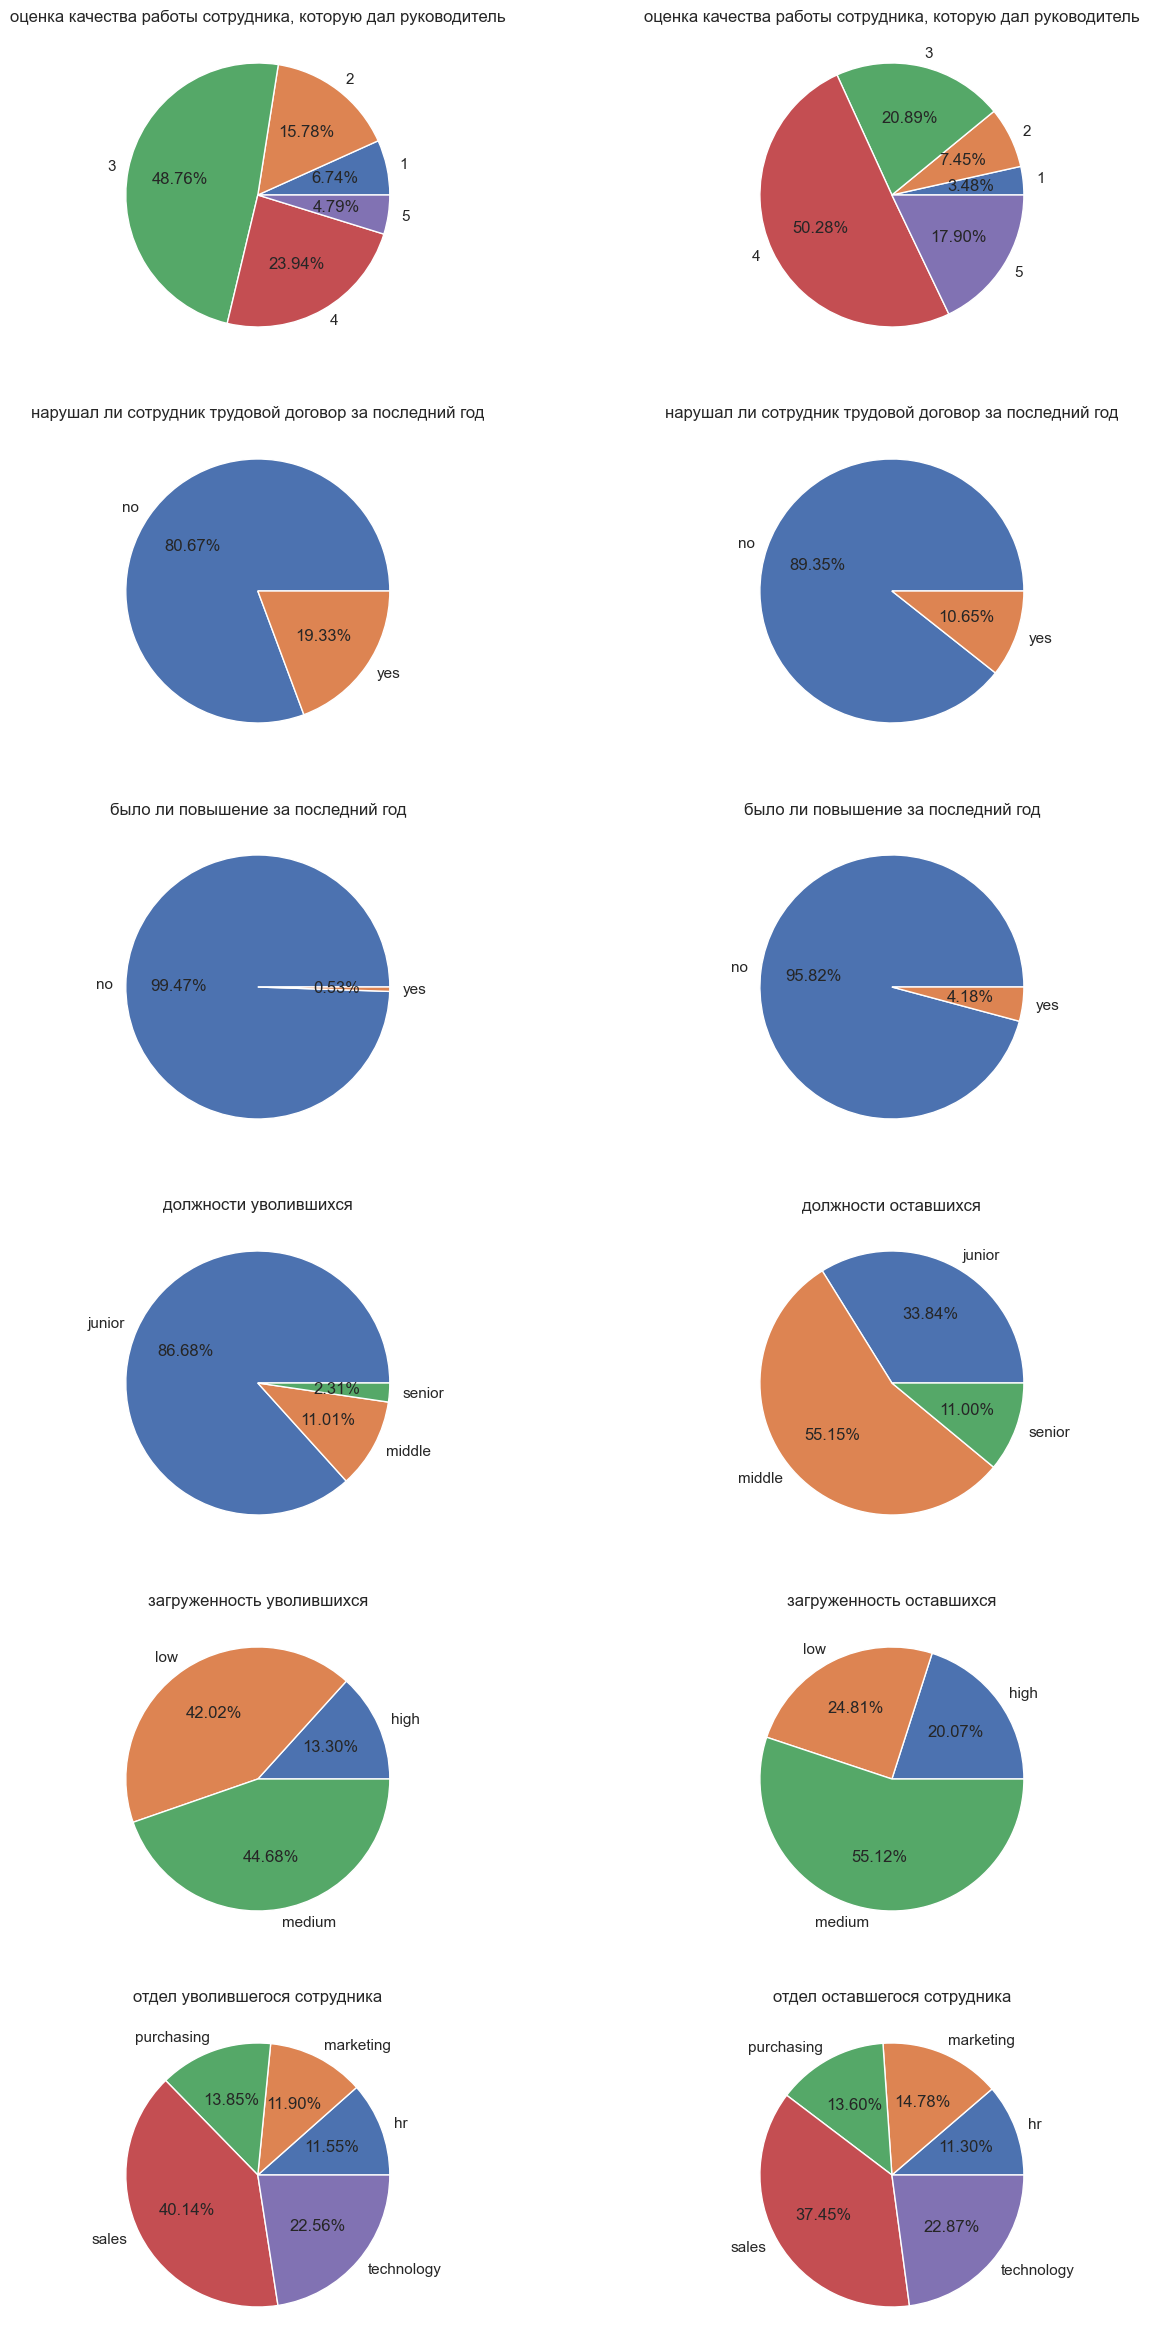

In [272]:
fig, ax = plt.subplots(6, 2, figsize=(15, 30))
pie_plot_ax(test_quit[test_quit['quit']=='yes'], title='оценка качества работы сотрудника, которую дал руководитель',
         index='supervisor_evaluation',values='id',aggfunc='count',ax = ax[0, 0])
pie_plot_ax(test_quit[test_quit['quit']=='no'], title='оценка качества работы сотрудника, которую дал руководитель',
         index='supervisor_evaluation',values='id',aggfunc='count',ax = ax[0, 1])

pie_plot_ax(test_quit[test_quit['quit']=='yes'], title='нарушал ли сотрудник трудовой договор за последний год',
         index='last_year_violations',values='id',aggfunc='count',ax = ax[1, 0])
pie_plot_ax(test_quit[test_quit['quit']=='no'], title='нарушал ли сотрудник трудовой договор за последний год',
         index='last_year_violations',values='id',aggfunc='count',ax = ax[1, 1])

pie_plot_ax(test_quit[test_quit['quit']=='yes'],title='было ли повышение за последний год',
         index='last_year_promo',values='id',aggfunc='count',ax = ax[2, 0])
pie_plot_ax(test_quit[test_quit['quit']=='no'],title='было ли повышение за последний год',
         index='last_year_promo',values='id',aggfunc='count',ax = ax[2, 1])

pie_plot_ax(test_quit[test_quit['quit']=='yes'],title='должности уволившихся',
         index='level',values='id',aggfunc='count',ax = ax[3, 0])
pie_plot_ax(test_quit[test_quit['quit']=='no'],title='должности оставшихся',
         index='level',values='id',aggfunc='count',ax = ax[3, 1])

pie_plot_ax(test_quit[test_quit['quit']=='yes'],title='загруженность уволившихся',
         index='workload',values='id',aggfunc='count',ax = ax[4, 0])
pie_plot_ax(test_quit[test_quit['quit']=='no'],title='загруженность оставшихся',
         index='workload',values='id',aggfunc='count',ax = ax[4, 1])

pie_plot_ax(test_quit[test_quit['quit']=='yes'],title='отдел уволившегося сотрудника',
         index='dept',values='id',aggfunc='count',ax = ax[5, 0])
pie_plot_ax(test_quit[test_quit['quit']=='no'],title='отдел оставшегося сотрудника',
         index='dept',values='id',aggfunc='count',ax = ax[5, 1])

plt.show()

<Figure size 800x550 with 0 Axes>

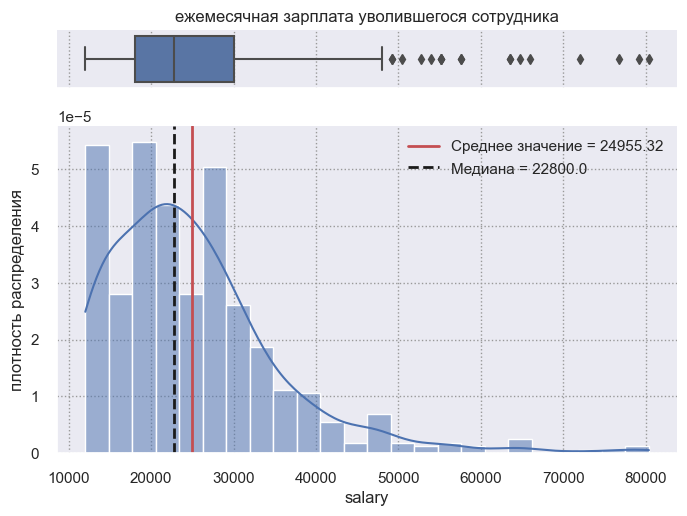

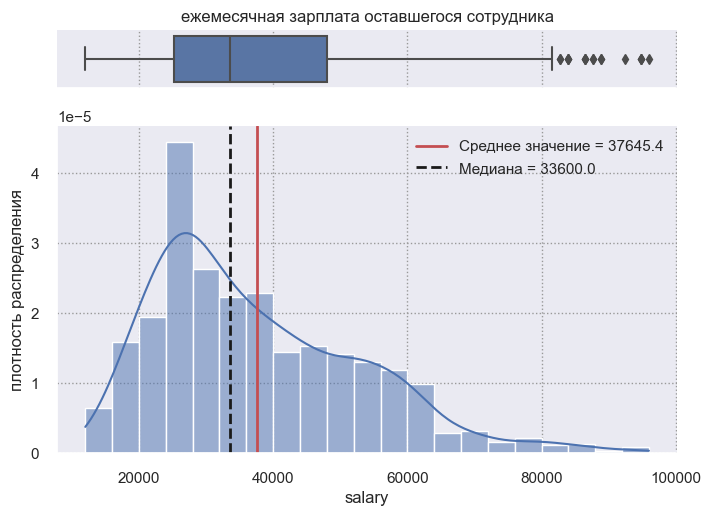

In [273]:
plt.figure(0)
hist_underbox_norm(test_quit.loc[test_quit['quit']=='yes','salary'],title='ежемесячная зарплата уволившегося сотрудника')
plt.figure(1)
hist_underbox_norm(test_quit.loc[test_quit['quit']=='no','salary'],title='ежемесячная зарплата оставшегося сотрудника')
plt.show()

<Figure size 800x550 with 0 Axes>

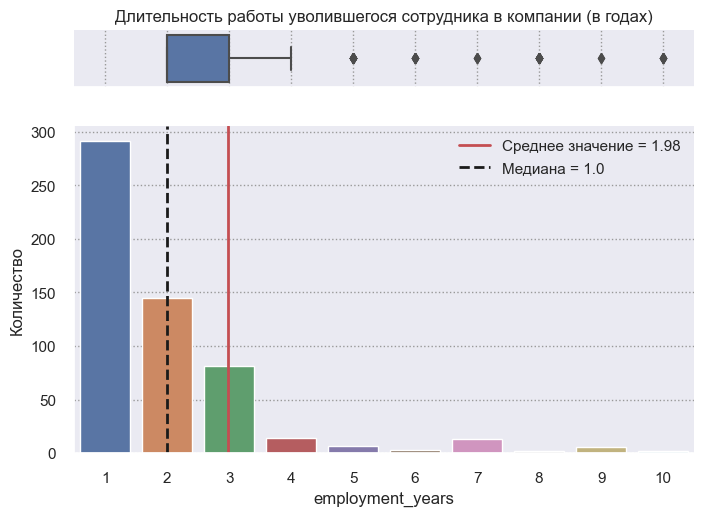

<Figure size 800x550 with 0 Axes>

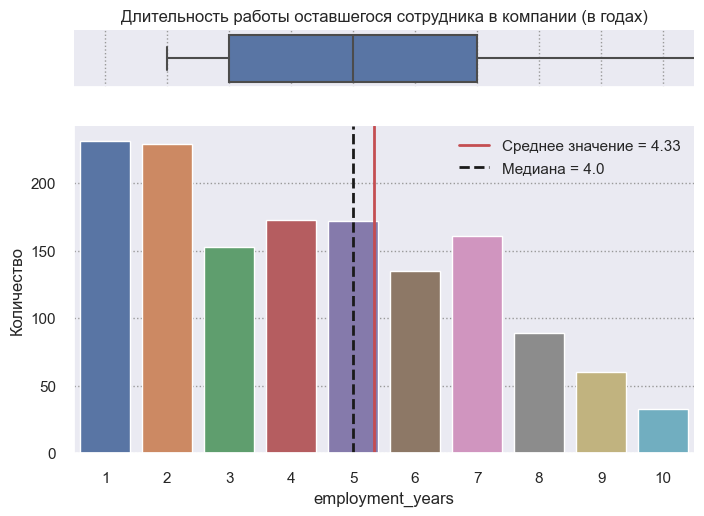

In [274]:
plt.figure(0);
countplot_underbox(test_quit.loc[test_quit['quit']=='yes','employment_years'],title='Длительность работы уволившегося сотрудника в компании (в годах)');
plt.figure(2);
countplot_underbox(test_quit.loc[test_quit['quit']=='no','employment_years'],title='Длительность работы оставшегося сотрудника в компании (в годах)');
plt.show();

Видим, что инфографика по тестовым данным не существенно отличается от инфографики по тренировочным данным.

## Корреляционный анализ

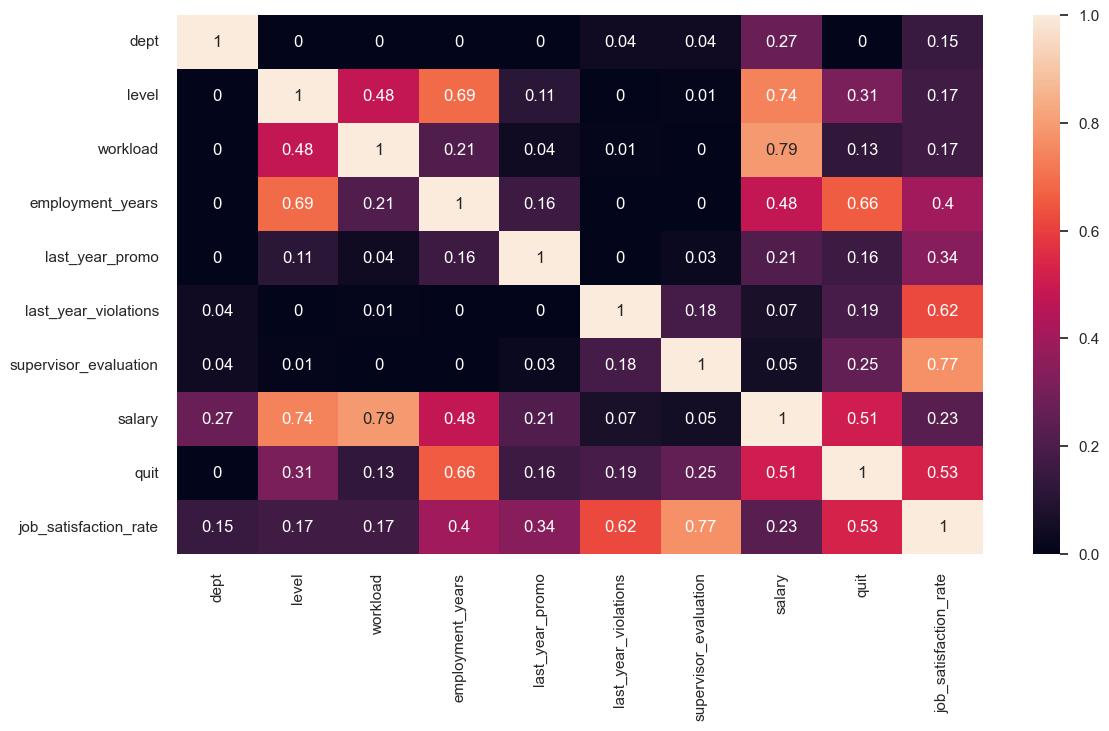

In [275]:
fig, ax = plt.subplots(figsize=(13, 7))
sns.heatmap(round(train_quit.drop('id',axis=1)
                  .phik_matrix(interval_cols=['salary','job_satisfaction_rate']),2),annot=True);

### вывод

- мультиколлинеарность не наблюдаем
- наблюдаем заметные корреляции целевого признака с `employment_years`, `salary` и `job_satisfaction_rate`

### Сравним распределения признака job_satisfaction_rate для ушедших и оставшихся сотрудников

<Figure size 800x550 with 0 Axes>

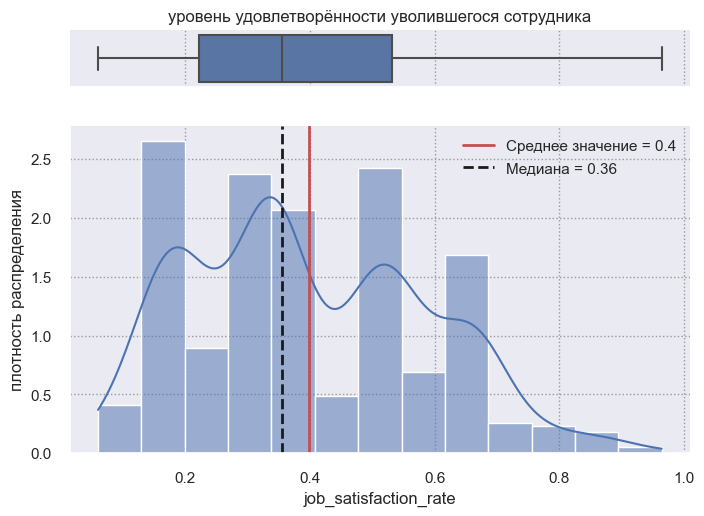

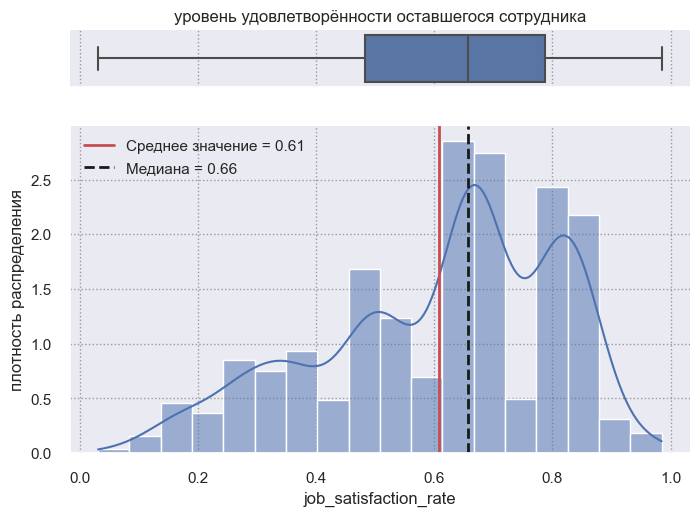

In [276]:
plt.figure(0)
hist_underbox_norm(test_quit.loc[test_quit['quit']=='yes','job_satisfaction_rate'],title='уровень удовлетворённости уволившегося сотрудника')
plt.figure(1)
hist_underbox_norm(test_quit.loc[test_quit['quit']=='no','job_satisfaction_rate'],title='уровень удовлетворённости оставшегося сотрудника')
plt.show()

Видим, что оставшиеся сотрудники более удовлетворены работой в компании, чем ушедшие (у первых медиана оценки равна 0.66, у вторых равна 0.36)

## Вывод

- "отличников" (оценка руководителя = 5) ***у не уволившихся*** сотрудников в три раза больше, "хорошистов" - почти в два раза. Тогда как среди уволившихся почти в два раза больше "троешников", как и сотрудников с неудовлетворительным качеством работы
- среди уволившихся сотрудников нарушали трудовой договор за последний год почти в 2 раза чаще
- в 43 раза чаще давали повышение сотрудникам, которые по итогу остались
- из уволившихся всего 1.51% - сотрудники должности "senior", тогда как "middle" сотрудников - 9.57%, и 88.92% - "junior"
- оставшиеся сотрудники работали больше - средняя и высокая загруженность сотрудника встречались заметно чаще (56.75% и 19.25% соответственно против 43.26% и 10.73 у уволившихся)
- зарплаты оставшихся сотрудников в среднем на 14 больше, чем у уволившихся (медианная зарплата больше на 12)
- медианное значение стажа работы среди уволившихся равно 1 году, среди оставшихся - 4
- оставшиеся сотрудники более удовлетворены работой в компании, чем ушедшие (у первых медиана оценки равна 0.65, у вторых равна 0.36)
- инфографика по тестовым данным не существенно отличается от инфографики по тренировочным данным.
- мультиколлинеарность не наблюдаем
- наблюдаем заметные корреляции целевого признака с `employment_years`, `salary` и `job_satisfaction_rate`


# Шаг 4-5. Подготовка данных

In [291]:
RANDOM_STATE = 42

X_train_quit = train_quit.drop(['id'], axis=1).drop_duplicates().copy()
X_train_quit = X_train_quit.drop(['quit'], axis=1)

y_train_quit = train_quit.drop(['id'], axis=1).drop_duplicates().copy()
y_train_quit = y_train_quit['quit']

X_test_quit = test_quit.drop(['quit','id'], axis=1)

y_test_quit = test_quit['quit']

X_train_quit.shape, X_test_quit.shape

((2587, 9), (2000, 9))

In [292]:
y_train_quit.shape, y_test_quit.shape

((2587,), (2000,))

In [293]:
# создаём списки с названиями признаков
ohe_columns = ['dept','last_year_promo','last_year_violations']
ord_columns = ['workload','level']
num_columns = ['employment_years','supervisor_evaluation',
               'salary','job_satisfaction_rate']

In [294]:
# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
    )
# создаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
# SimpleImputer + OE
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['low', 'medium','high'],
                    ['junior', 'middle', 'senior']
                ]
            )
        ),
    ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

# Шаг 6. Обучение модели

Метрика оценки качества в этой задаче — ROC-AUC. Критерий успеха: ROC-AUC $≥0.91$ на тестовой выборке.

In [305]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 13),
        'models__max_features': range(2, 13),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 11),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    
    # словарь для модели LogisticRegression() 
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE, kernel='linear')],
        'models__C': [0.1, 1, 10],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

In [306]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train_quit, y_train_quit)

best_model = randomized_search.best_estimator_
best_params = randomized_search.best_params_

# Оцениваем качество на тестовой выборке
y_test_pred_quit = best_model.predict(X_test_quit)
y_test_pred_quit_proba = best_model.predict_proba(X_test_quit)

le = LabelEncoder()
y_test_quit_encoded = le.fit_transform(y_test_quit)
y_test_pred_quit_encoded = le.transform(y_test_pred_quit)

print('Лучшая модель и её параметры:\n\n', best_model)
print ('Метрика (ROC-AUC) лучшей модели на кросс-валидации:', 
       round(randomized_search.best_score_,3))
print('\n Метрика ROC-AUC на тестовой выборке:',
      round(roc_auc_score(y_test_quit_encoded, y_test_pred_quit_proba[:,1]),3))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                            

# Шаг 7. Выводы

## Вывод

- Лучшая модель: 

```python
'preprocessor__num': StandardScaler(),
 'models__max_features': 11,
 'models__max_depth': 5,
 'models': DecisionTreeClassifier(random_state=42)
```

- Метрика ROC-AUC на тестовой выборке: 0.92

Перед получением данного результата было проведено моделирование без исключения признакак `dept` - лучшей моделью была линейная регрессия со значением ROC-AUC на тестовой выборке в 0.904, после чего была предпринято решение попробовать провести моделирование исключив данный признак на основании того, что целевая переменная никак не коррелирует с данным признаком (см. раздел "корреляционный анализ" в шаге 3).

Вполне возможно, что это обусловлено тем, что `DecisionTreeClassifier` с кластеризированными данными и с нелинейными отношениями в данных работает лучше, чем линейная регрессия, которая сильно зависит от наличия линейных зависимостей в данных.

# Общий вывод

***Поставленные задачи:***

1. Построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. 

2. Построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

***Этапы работы:***

    - провели исследователский анализ данных в обеих задачах
    - подготовили данные для обучения моделей в обеих задачах
    - подобрали лучшие модели для каждой задачи

***Выводы и дополнительные предложения для бизнеса:***

Если значение уровня удовлетворенности сотрудника его работой в компании в 0.5 можно принять за пороговое значение, по которому можно сказать удовлетворен / не удовлетворен, то видим, что:
- в отделе `purchasing` удовлетворены все
- в отделе `technology` не удовлетворены работой только сотрудники в должности `senior` со средним уровнем загруженности
- в отделе `hr` не удовлетворены только `junior`-сотрудники со средней загруженностью
- в отделе `sales` не удовлетворены работой сотрудники в должности `senior` со средним и высоким уровнями загруженности
- в отделе `marketing` не удовлетворены работой сотрудники должности `junior` со средней и высокой загруженностями, сотрудники с должностью `middle` со средним уровнем загруженности, а так же `senior` с низким и средним уровнями загруженности

Также, если поделить сотрудников по порогу в 0.5 и построить для обеих групп свою инфографику (см. Приложение), как в начале этого шага, то для обоих групп выясняется следующее:

- удовлетворенным сотрудникам более чем в два раза чаще давали повышение за последний год, чем неудовлетворенным (4.03% vs 1.66%)
- удовлетворенные сотрудники почти в 5 раз реже нарушали трудовой договор, чем неудовлетворенные
- оценки качества работы удовлетворенных сотрудников, которые дал руководитель, тоже заметно отличаются: "отличников" в 9 раз больше, "хорошистов" в 8 больше, "троишников" в 6 раз меньше, а сотрудников с неудовлетворительным качеством работы в 12 раз меньше, чем у неудовлетворенных сотрудников
- длительность работы в компании у удовлетворенных сотрудников в среднем больше на полгода
- ежемесячная зарплата удовлетворенного работой сотрудника в среднем больше на 2400

- "отличников" (оценка руководителя = 5) ***у не уволившихся*** сотрудников в три раза больше, "хорошистов" - почти в два раза. Тогда как среди уволившихся почти в два раза больше "троешников", как и сотрудников с неудовлетворительным качеством работы
- среди уволившихся сотрудников нарушали трудовой договор за последний год почти в 2 раза чаще
- в 43 раза чаще давали повышение сотрудникам, которые по итогу остались
- из уволившихся всего 1.51% - сотрудники должности "senior", тогда как "middle" сотрудников - 9.57%, и 88.92% - "junior"
- оставшиеся сотрудники работали больше - средняя и высокая загруженность сотрудника встречались заметно чаще (56.75% и 19.25% соответственно против 43.26% и 10.73 у уволившихся)
- зарплаты оставшихся сотрудников в среднем на 14 едениц больше, чем у уволившихся (медианная зарплата больше на 12 едениц)
- медианное значение стажа работы среди уволившихся равно 1 году, среди оставшихся - 4
- оставшиеся сотрудники более удовлетворены работой в компании, чем ушедшие (у первых медиана оценки равна 0.66, у вторых равна 0.36)
- инфографика по тестовым данным не существенно отличается от инфографики по тренировочным данным.
- мультиколлинеарность не наблюдаем
- наблюдаем заметные корреляции целевого признака с `employment_years`, `salary` и `job_satisfaction_rate`

В первой задаче лучше всего справилась модель 
```python
{'models': DecisionTreeRegressor(random_state=42),
 'models__max_depth': None,
 'models__min_samples_leaf': 1,
 'models__min_samples_split': 8,
 'preprocessor__num': MinMaxScaler()}
 ```
Метрика SMAPE на тестовой выборке равна: 13.6 %

Во второй задаче:

- Лучшая модель: 
```python
'preprocessor__num': StandardScaler(),
 'models__max_features': 11,
 'models__max_depth': 5,
 'models': DecisionTreeClassifier(random_state=42)
```

- Метрика ROC-AUC на тестовой выборке: 0.92

Вполне возможно, что это обусловлено тем, что DecisionTreeRegressor и DecisionTreeClassifier с кластеризированными данными и с нелинейными отношениями в данных работают лучше, чем линейная и логистическая регрессии, которые сильно зависят от наличия линейных зависимостей в данных.

***Дополнительные предложения для бизнеса:***
- узнать причины низкой эффективности уволившихся сотрудников (почему преобладают низкие значения оценок их руководителей) и частых нарушений трудового договора
- рассмотреть идею повышения зарплат некоторым группам сотрудников, так как это может быть одной из причин их недовольства работой в компании
- рассмотреть идею о дополнительных повышениях некоторых сотрудников, так как некоторым важно двигаться по карьерной лестнице, невозможность чего может вылиться в недовольство работой в компании, и стать причиной для поиска новой работы

# Приложение

Неудовлетворенные работой сотрудники (`job_satisfaction_rate` ≤ 0.5) в левом столбце, удовлетворенные - в правом:

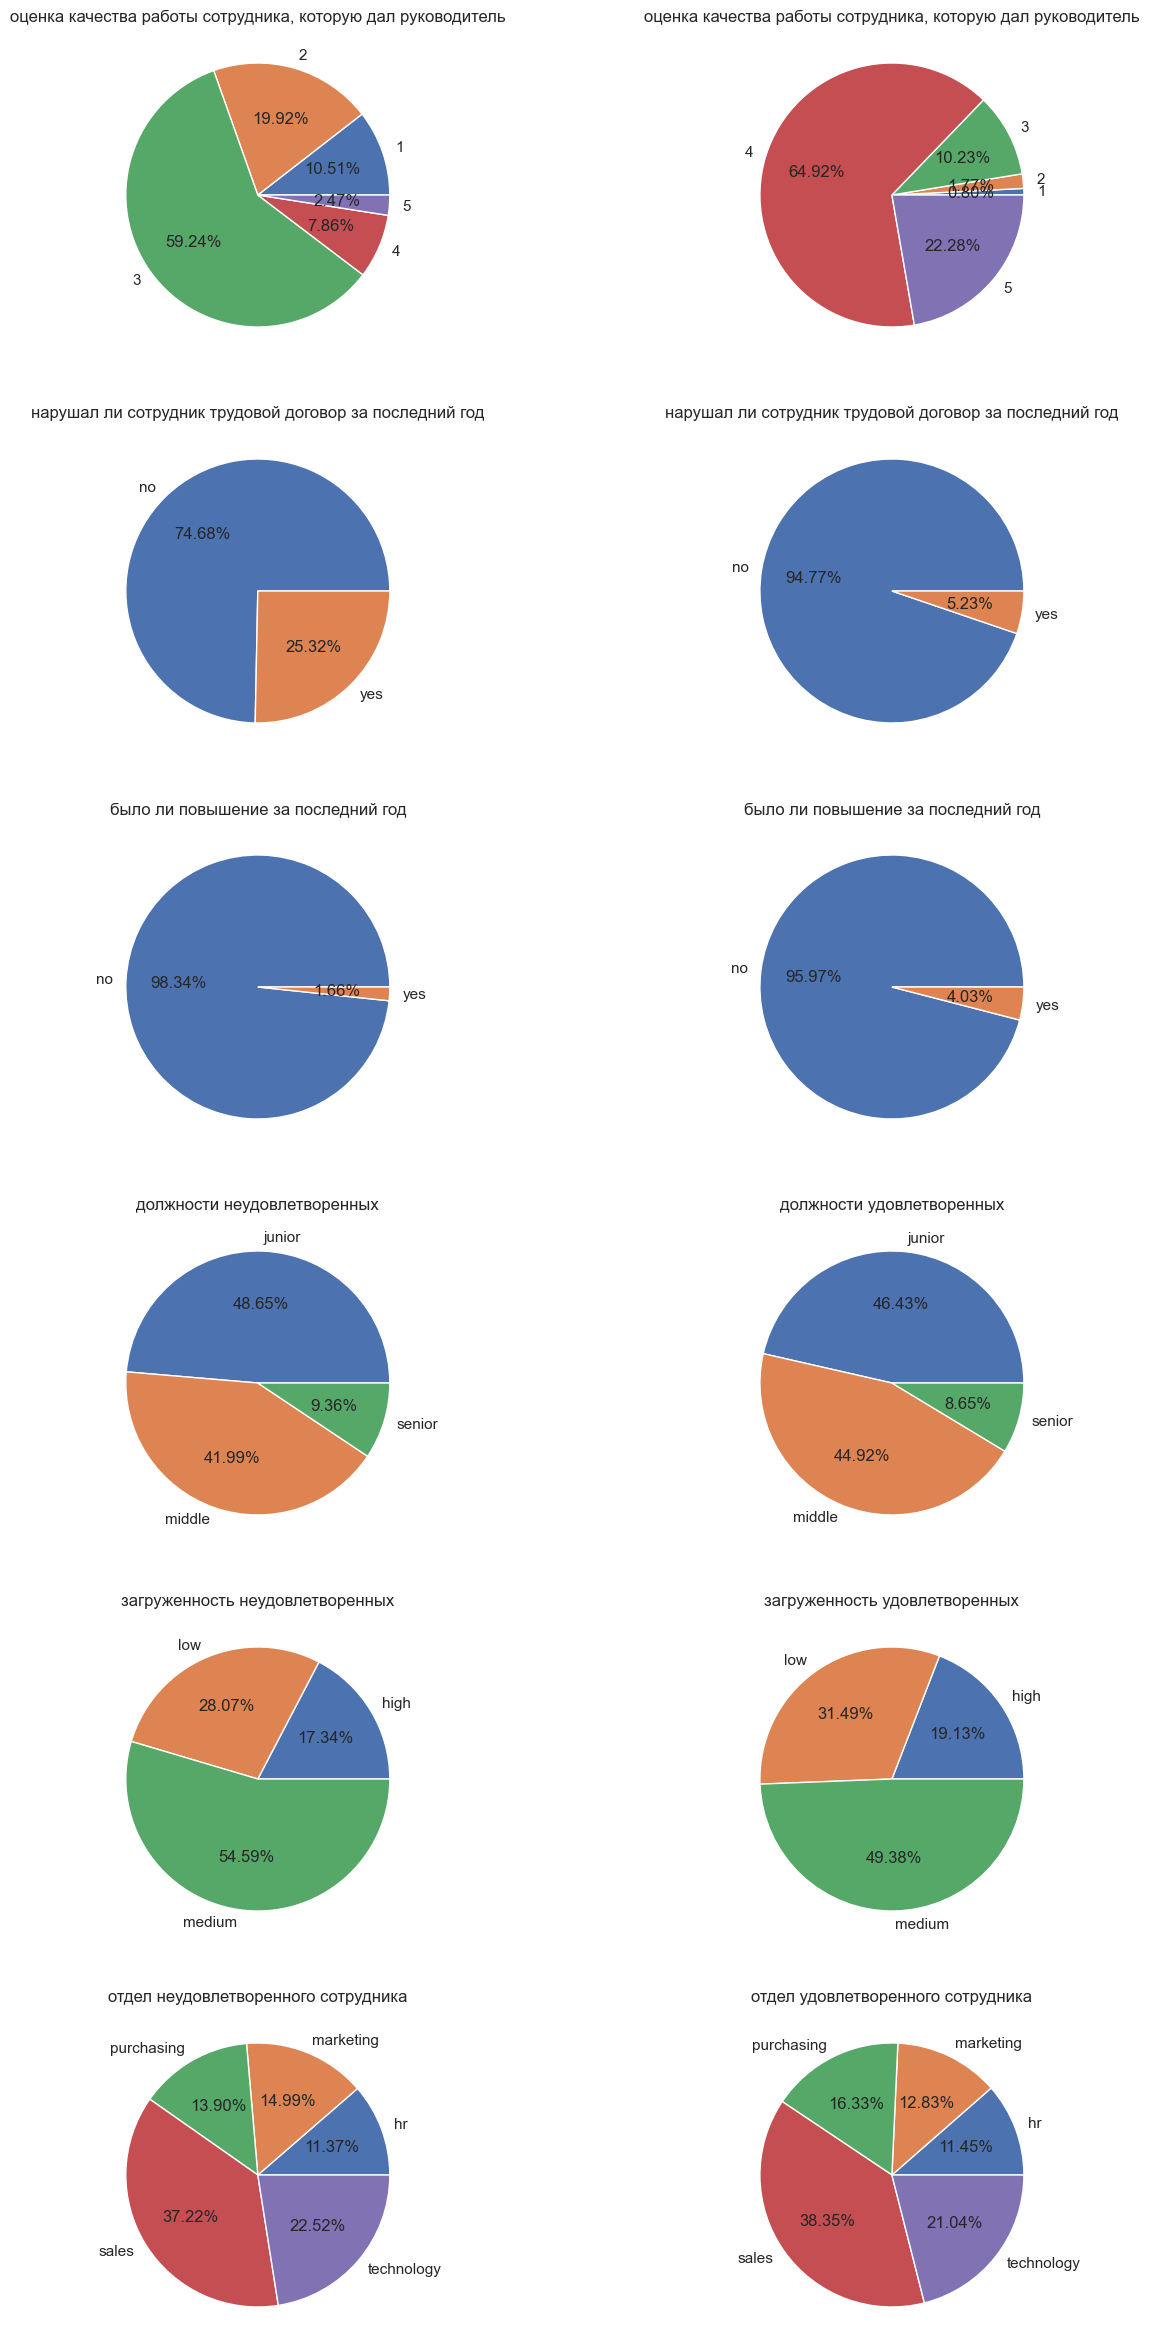

In [284]:
fig, ax = plt.subplots(6, 2, figsize=(15, 30))
pie_plot_ax(satisfaction_train[satisfaction_train['job_satisfaction_rate']<=0.5], title='оценка качества работы сотрудника, которую дал руководитель',
         index='supervisor_evaluation',values='id',aggfunc='count',ax = ax[0, 0])
pie_plot_ax(satisfaction_train[satisfaction_train['job_satisfaction_rate']>0.5], title='оценка качества работы сотрудника, которую дал руководитель',
         index='supervisor_evaluation',values='id',aggfunc='count',ax = ax[0, 1])

pie_plot_ax(satisfaction_train[satisfaction_train['job_satisfaction_rate']<=0.5], title='нарушал ли сотрудник трудовой договор за последний год',
         index='last_year_violations',values='id',aggfunc='count',ax = ax[1, 0])
pie_plot_ax(satisfaction_train[satisfaction_train['job_satisfaction_rate']>0.5], title='нарушал ли сотрудник трудовой договор за последний год',
         index='last_year_violations',values='id',aggfunc='count',ax = ax[1, 1])

pie_plot_ax(satisfaction_train[satisfaction_train['job_satisfaction_rate']<=0.5],title='было ли повышение за последний год',
         index='last_year_promo',values='id',aggfunc='count',ax = ax[2, 0])
pie_plot_ax(satisfaction_train[satisfaction_train['job_satisfaction_rate']>0.5],title='было ли повышение за последний год',
         index='last_year_promo',values='id',aggfunc='count',ax = ax[2, 1])

pie_plot_ax(satisfaction_train[satisfaction_train['job_satisfaction_rate']<=0.5],title='должности неудовлетворенных',
         index='level',values='id',aggfunc='count',ax = ax[3, 0])
pie_plot_ax(satisfaction_train[satisfaction_train['job_satisfaction_rate']>0.5],title='должности удовлетворенных',
         index='level',values='id',aggfunc='count',ax = ax[3, 1])

pie_plot_ax(satisfaction_train[satisfaction_train['job_satisfaction_rate']<=0.5],title='загруженность неудовлетворенных',
         index='workload',values='id',aggfunc='count',ax = ax[4, 0])
pie_plot_ax(satisfaction_train[satisfaction_train['job_satisfaction_rate']>0.5],title='загруженность удовлетворенных',
         index='workload',values='id',aggfunc='count',ax = ax[4, 1])

pie_plot_ax(satisfaction_train[satisfaction_train['job_satisfaction_rate']<=0.5],title='отдел неудовлетворенного сотрудника',
         index='dept',values='id',aggfunc='count',ax = ax[5, 0])
pie_plot_ax(satisfaction_train[satisfaction_train['job_satisfaction_rate']>0.5],title='отдел удовлетворенного сотрудника',
         index='dept',values='id',aggfunc='count',ax = ax[5, 1])

plt.show()

<Figure size 800x550 with 0 Axes>

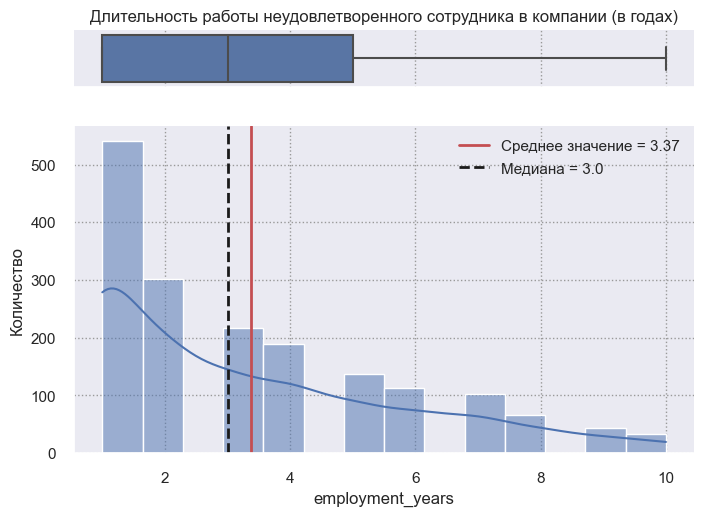

<Figure size 800x550 with 0 Axes>

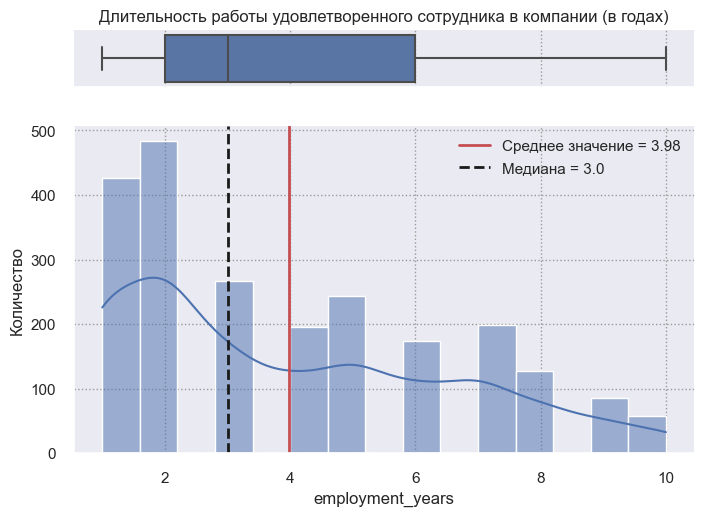

In [285]:
plt.figure(0);
hist_underbox(satisfaction_train.loc[satisfaction_train['job_satisfaction_rate']<=0.5,'employment_years'],title='Длительность работы неудовлетворенного сотрудника в компании (в годах)');
plt.figure(2);
hist_underbox(satisfaction_train.loc[satisfaction_train['job_satisfaction_rate']>0.5,'employment_years'],title='Длительность работы удовлетворенного сотрудника в компании (в годах)');
plt.show();

<Figure size 800x550 with 0 Axes>

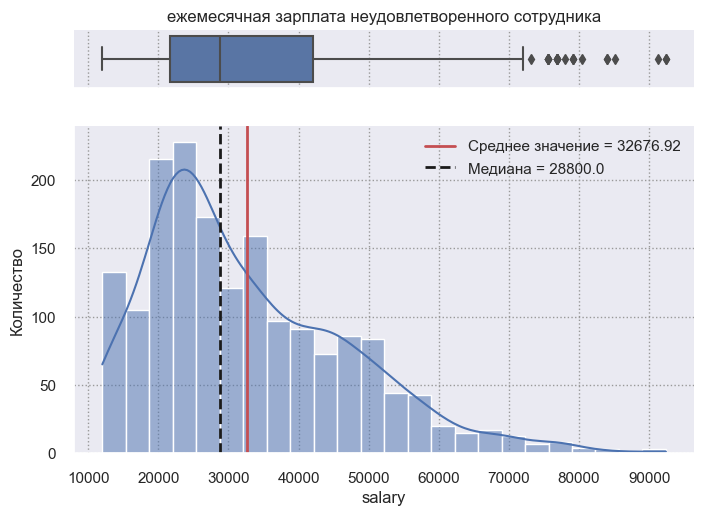

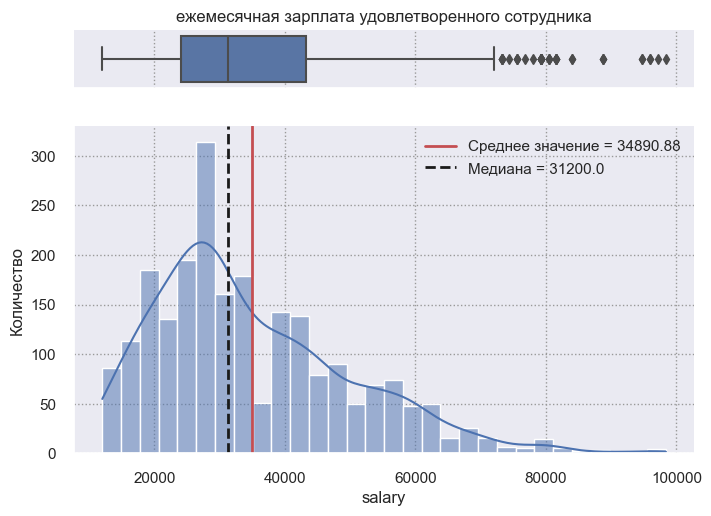

In [286]:
plt.figure(0)
hist_underbox(satisfaction_train.loc[satisfaction_train['job_satisfaction_rate']<=0.5,'salary'],title='ежемесячная зарплата неудовлетворенного сотрудника')
plt.figure(1)
hist_underbox(satisfaction_train.loc[satisfaction_train['job_satisfaction_rate']>0.5,'salary'],title='ежемесячная зарплата удовлетворенного сотрудника')
plt.show()